In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import argparse
import os
import shutil
import time
import random
import copy


import torch
from sklearn.metrics import precision_score,recall_score
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose

import torchmetrics

#from torchinfo import summary

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
import torch.nn.parallel
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, random_split
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

In [3]:
import argparse
import os
import shutil
import time
import random
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [4]:
import torch
import torch.nn as nn

torch.autograd.set_detect_anomaly(True)

In [5]:
class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(CustomBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.layers(x)
        out += self.shortcut(identity)
        out = nn.ReLU(inplace=True)(out)
        return out

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.layers = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1[0],
            resnet18.layer1[1],
            CustomBlock(64,64),
            resnet18.layer2[0],
            resnet18.layer2[1],
            CustomBlock(128, 128, stride=2),  # Added custom block to layer2
            resnet18.layer3[0],
            resnet18.layer3[1],
            resnet18.layer4[0],
            
        )

    def forward(self, x):
        return self.layers(x) 

In [7]:
# Instantiate the model
model =  FeatureExtractor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 7018944


In [8]:
# Instantiate the model
model = FeatureExtractor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.weight - 1728
layers.1.weight - 64
layers.1.bias - 64
layers.4.conv1.weight - 36864
layers.4.bn1.weight - 64
layers.4.bn1.bias - 64
layers.4.conv2.weight - 36864
layers.4.bn2.weight - 64
layers.4.bn2.bias - 64
layers.5.conv1.weight - 36864
layers.5.bn1.weight - 64
layers.5.bn1.bias - 64
layers.5.conv2.weight - 36864
layers.5.bn2.weight - 64
layers.5.bn2.bias - 64
layers.6.layers.0.weight - 36864
layers.6.layers.1.weight - 64
layers.6.layers.1.bias - 64
layers.6.layers.3.weight - 36864
layers.6.layers.4.weight - 64
layers.6.layers.4.bias - 64
layers.6.layers.6.weight - 36864
layers.6.layers.7.weight - 64
layers.6.layers.7.bias - 64
layers.7.conv1.weight - 73728
layers.7.bn1.weight - 128
layers.7.bn1.bias - 128
layers.7.conv2.weight - 147456
layers.7.bn2.weight - 128
layers.7.bn2.bias - 128
layers.7.downsample.0.weight - 8192
layers.7.downsample.1.weight - 128
layers.7.downsample.1.bias - 128
layers.8.conv1.weight - 147456
layers.8.bn1.weight - 128
layers.8.bn1.bias - 128
layers

In [9]:
class Predictor(nn.Module):
    def __init__(self, num_classes=10):
        super(Predictor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
# Instantiate the model
model =  Predictor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4725770


In [11]:
# Instantiate the model
model = Predictor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 5120
layers.3.bias - 10


In [12]:
class Attacker(nn.Module):
    def __init__(self, num_classes=1):
        super(Attacker, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes),
        )

    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x

In [13]:
# Instantiate the model
model =  Attacker()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4721153


In [14]:
# Instantiate the model
model = Attacker()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 512
layers.3.bias - 1


In [15]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].shape[0] == tensor.shape[0] for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        X = self.tensors[0][index]
        if self.transform is not None:
            X = self.transform(X)
        return X, tuple(self.tensors[i][index] for i in range(1, len(self.tensors)))
    
    def __len__(self):
        return self.tensors[0].shape[0]

In [16]:
tfms = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 100


#50k clf_trainds
clf_trainds = CIFAR10(root='PyTorch-StudioGAN/data/', transform=tfms,download=True)

#clf_train_idx = 25k
#clf_test_idx = 25k
clf_train_idx, clf_test_idx = train_test_split(
    np.arange(len(clf_trainds.targets)), test_size=0.5, shuffle=True, stratify=clf_trainds.targets
)
train_sampler = sampler.SubsetRandomSampler(clf_train_idx)
test_sampler = sampler.SubsetRandomSampler(clf_test_idx)

#creating clf_train and clf_test dataloader
clf_train_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=train_sampler)
clf_test_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=test_sampler)

#creating attacker dataset
y_true_atk = [t for t in clf_trainds.targets]
#25k 0 and 25k 1
y_atk = np.zeros(len(clf_trainds), dtype=int)
y_atk[clf_train_idx.tolist()] = 1

atk_trainds = CustomTensorDataset(
    tensors=(clf_trainds.data,torch.tensor(y_true_atk), torch.tensor(y_atk)),
    transform=tfms
)
atk_train_idx, atk_test_idx = train_test_split(
    np.arange(len(atk_trainds.tensors[2].tolist())), test_size=0.2, shuffle=True, stratify=atk_trainds.tensors[2].tolist()
)
atk_train_sampler = sampler.SubsetRandomSampler(atk_train_idx)
atk_test_sampler = sampler.SubsetRandomSampler(atk_test_idx)

atk_train_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_train_sampler)
atk_test_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_test_sampler)



Files already downloaded and verified


In [17]:

def adjust_learning_rate(epoch, init_lr=0.001):
    schedule = [12]
    cur_lr = init_lr
    for schedule_epoch in schedule:
        if epoch >= schedule_epoch:
            cur_lr *= 0.1
    return cur_lr

In [17]:
def add_gaussian_noise(tensor, mean=0., std_dev=1):
    return tensor + torch.randn(tensor.size()).cuda() * std_dev + mean

In [18]:
#pretraining FE+CF
criterion = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
test_acc = []

def train_FE_CF2(FE, CF, data_train_loader, current_lr, vis=None):
    FE.train()
    CF.train()
    FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    for i, (images, labels) in enumerate(data_train_loader):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        
        features = FE(images)
        
        # feed only private images to the classifier
        output_CF = CF(features)
        loss_CF = criterion(output_CF, labels)
        

        FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        FE_optimizer.step()
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\t'.format(
                i, i * len(images), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item()))

    return FE, CF

In [19]:
def test_FE_CF2(FE, CF, data_test_loader):
    FE.eval()
    CF.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #size= len(data_test_loader)//2

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_test_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            features = FE(images)
            #classfier_features= features[privlabe==1]
            output = CF(features)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            avg_acc += pred.eq(labels.view_as(pred)).sum()
            counter += 1

    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)

In [22]:
test_atk_loss=[]  # list to store loss values
def eval_clf(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            #features = add_gaussian_noise(features)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            test_atk_loss.append(loss)  # add loss to list
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [23]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file = os.path.join(save_dir, 'FE.pth')
cf_model_file = os.path.join(save_dir, 'CF.pth')
inf_model_file=os.path.join(save_dir,'INF.pth')

In [24]:
total_epoch=300
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)
def get_FE_CF():
    FE = FeatureExtractor()
    CF = Predictor()
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            FE = torch.nn.DataParallel(FE)
            CF = torch.nn.DataParallel(CF)
        FE = FE.cuda()
        CF = CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, CF = train_FE_CF2(FE, CF, clf_train_dl, current_lr, vis=None)
            #test_FE_CF2(FE, CF, clf_test_dl)
            eval_clf(FE,CF,clf_test_dl,clf_criterion,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(CF.module, "Models/mix/pre_train/CF.pth")
    else:
        torch.save(FE, fe_model_file)
        torch.save(CF, cf_model_file)

    return FE, CF

In [25]:
#overfitting on data
FE, CF = get_FE_CF()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 2.743955	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 1.511469	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 1.325454	
Classifier Loss: 1.616774631023407 | Classifier Accuracy: 0.48579999804496765
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 1.106151	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 1.128596	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.998943	
Classifier Loss: 1.0293664662837982 | Classifier Accuracy: 0.6458799839019775
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.930720	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.900177	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.784110	
Classifier Loss: 0.8957139103412628 | Classifier Accuracy: 0.6931599974632263
epoch 3
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.726838	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.590051	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.768825	
Classifier Loss: 0.9392835783958435 | Classifier Accuracy: 0.68159

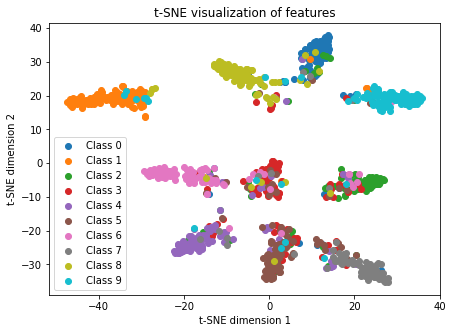

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def extract_features(model, dataloader, device, num_batches=None):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if num_batches and i >= num_batches:
                break
            inputs = inputs.to(device)
            features = model(inputs)
            features_flat = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features_flat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    features_array = np.vstack(features_list)
    labels_array = np.concatenate(labels_list)

    return features_array, labels_array

def apply_tsne(features):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)
    return reduced_features


def plot_tsne(reduced_features, labels):
    plt.figure(figsize=(7, 5))
    for i in range(10):  # assuming 10 classes in CIFAR-10
        plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], label=f'Class {i}')
    plt.legend()
    plt.title('t-SNE visualization of features')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

FE = torch.load(fe_model_file)
num_batches = 10
features, labels = extract_features(FE, clf_test_dl, device,num_batches)
reduced_features = apply_tsne(features)
plot_tsne(reduced_features, labels)

In [109]:
def add_noise_to_features(features, noise_level=0.01):
    """
    Add Gaussian noise to the features.
    
    Parameters:
    - features: The original features.
    - noise_level: Standard deviation of the Gaussian noise.
    
    Returns:
    - Noisy features.
    """
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

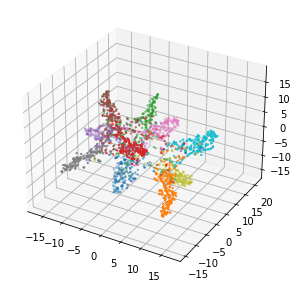

In [110]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def extract_features(model, dataloader, device, num_batches=None):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if num_batches and i >= num_batches:
                break
            inputs = inputs.to(device)
            features = model(inputs)
            features_flat = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features_flat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    features_array = np.vstack(features_list)
    labels_array = np.concatenate(labels_list)

    return features_array, labels_array

def apply_tsne(features):
    tsne = TSNE(n_components=3, random_state=0)
    reduced_features = tsne.fit_transform(features)
    return reduced_features


def plot_tsne_3d(reduced_features, labels):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    point_size = 2
    
    for i in range(10):  # assuming 10 classes in CIFAR-10
        ax.scatter(reduced_features[labels == i, 0], 
                   reduced_features[labels == i, 1], 
                   reduced_features[labels == i, 2], 
                   label=f'Class {i}',s=point_size)
    
    
    plt.show()

FE = torch.load(fe_model_file)
num_batches = 20
features, labels = extract_features(FE, clf_test_dl, device, num_batches)
noisy_features = add_noise_to_features(features)
reduced_features = apply_tsne(noisy_features)
#reduced_features = apply_tsne(features)
plot_tsne_3d(reduced_features, labels)

In [26]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad_(False) 
    model.eval()

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad_(True)
    model.train()

In [31]:
def get_precision_recall(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, predicted, average='macro',zero_division=0)
    recall = recall_score(labels, predicted, average='macro')
    return precision, recall

In [27]:
#train pretrained FE+attacker
device = 'cuda' if torch.cuda.is_available() else 'cpu'
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
#list for saving features 
#feature_list = []
#for plotting
#train_losses = []
def train_FE_INF(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(atk_train_dl):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)
        features = FE(X)
        #for plotting T-SNE
        #feature_list.append(features.detach().cpu().numpy())
        # feed them to the inf model
        pred_private_labels = INF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        ######
        #train_losses.append(loss_INF.item())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.detach().item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return FE, INF

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

INF_test_loss = []
INF_test_acc = []
loss_fn = nn.BCEWithLogitsLoss().to(device)

def test_FE_INF(FE, INF_model, data_test_loader, device):
    FE.eval()
    INF_model.eval()
    
    true_labels_test = []
    predicted_scores_test = []
    
    avg_loss = 0.0
    avg_acc=0.0
    counter=0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for i, (X, (_, y2)) in enumerate(data_test_loader):
            X, y2 = X.to(device), y2.to(device)
            features = FE(X)
            output = INF_model(features)
            
            predicted_scores_test.extend(output.squeeze().detach().cpu().numpy())
            true_labels_test.extend(y2.cpu().numpy())
            y2= y2.unsqueeze(1)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)
            
            
    # Compute and plot the ROC curve
    fpr, tpr, _ = roc_curve(true_labels_test, predicted_scores_test)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Usage example
# test_FE_INF(FE, INF, atk_test_dl, device)


In [34]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_FE_INF(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
#           private_labels,n=private_labels_gaining(labels)
            features = FE(X)
            output = INF_model(features)
            #output=torch.round(output)
            #y2=y2.float()
            y2= y2.unsqueeze(1)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)

In [38]:
total_epoch=100
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_FE_INF():
    FE = torch.load(fe_model_file)
    INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, INF = train_FE_INF(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_FE_INF(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(INF.module, "Models/mix/pre_train/CF.pth")
    else:
        #torch.save(FE, fe_model_file)
        torch.save(INF, inf_model_file)
    return FE, INF

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.747416	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.671973	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.680346	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.674701	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.671624, Accuracy: 60.970000


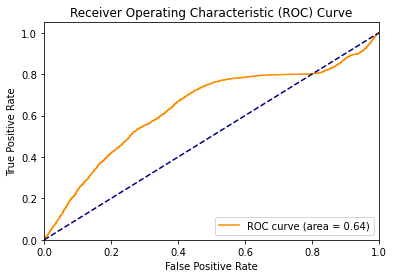

epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.678391	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.676515	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.659854	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.663381	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Test Avg. Loss: 0.670434, Accuracy: 61.830000


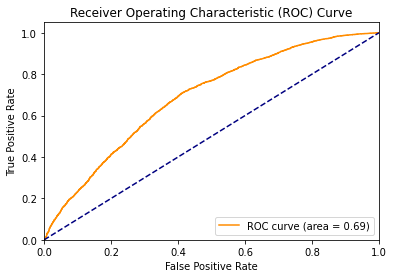

epoch 2
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.684455	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.638779	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.666301	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.648105	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.669600, Accuracy: 58.400000


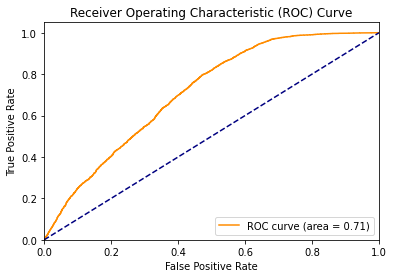

epoch 3
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.714310	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.683096	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.682318	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.700097	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.666169, Accuracy: 59.410000


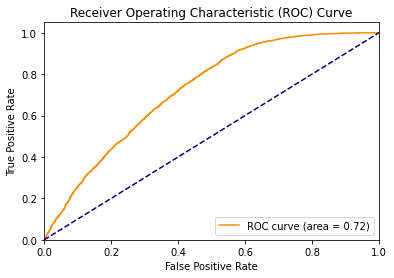

epoch 4
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.656603	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.682859	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.663433	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.688071	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.665752, Accuracy: 59.500000


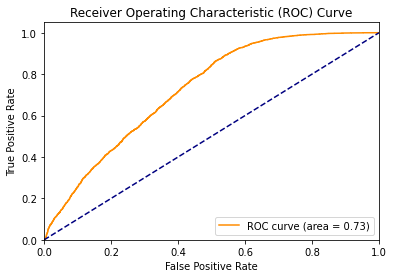

epoch 5
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.656611	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.705474	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.702860	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.700959	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.665896, Accuracy: 61.520000


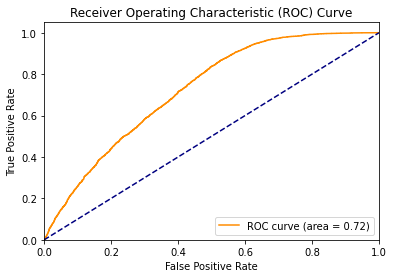

epoch 6
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.632386	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.706612	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.676018	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.686518	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Test Avg. Loss: 0.665529, Accuracy: 61.530000


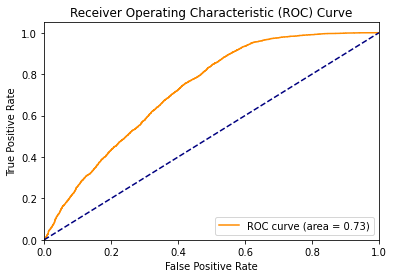

epoch 7
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.677646	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.606606	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.674829	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.640423	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.665368, Accuracy: 58.980000


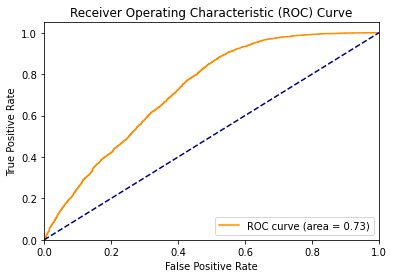

epoch 8
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.698703	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.701325	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.646644	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.697563	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.663565, Accuracy: 62.030000


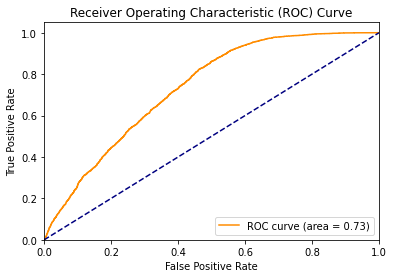

epoch 9
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.666580	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.663511	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.699759	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.657904	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.666096, Accuracy: 59.590000


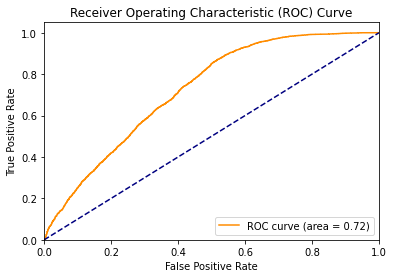

epoch 10
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.626438	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.690307	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.648708	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.664546	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.664153, Accuracy: 59.890000


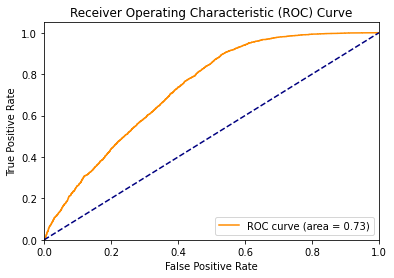

epoch 11
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.677765	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.680593	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.676424	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.674749	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.664136, Accuracy: 60.710000


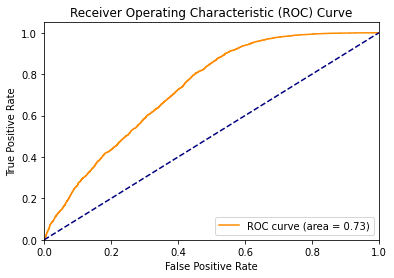

epoch 12
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.653546	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.644708	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.624532	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.676979	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.663035, Accuracy: 60.480000


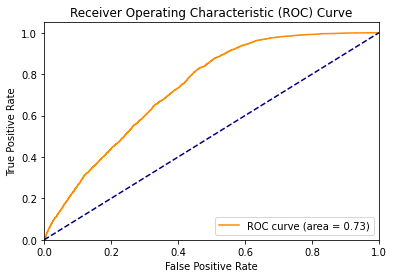

epoch 13
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.664503	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.680320	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.686123	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.633607	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.663280, Accuracy: 60.710000


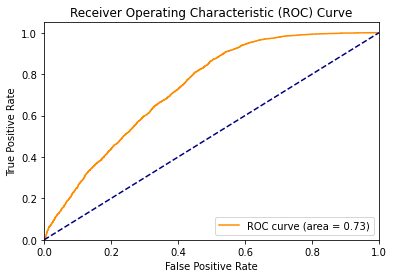

epoch 14
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.657951	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.647180	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694504	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.689731	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Test Avg. Loss: 0.663063, Accuracy: 60.760000


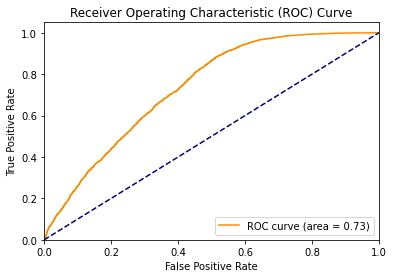

epoch 15
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.683876	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.659621	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.681832	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.635397	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.662930, Accuracy: 60.650000


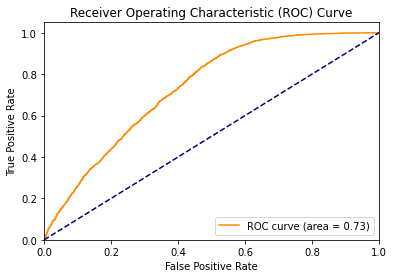

epoch 16
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.631496	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.682197	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.675903	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.640410	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.662513, Accuracy: 60.760000


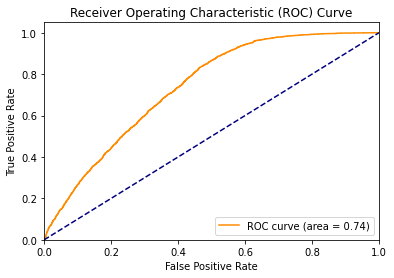

epoch 17
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.652489	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.708978	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.622693	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.638388	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.662461, Accuracy: 60.990000


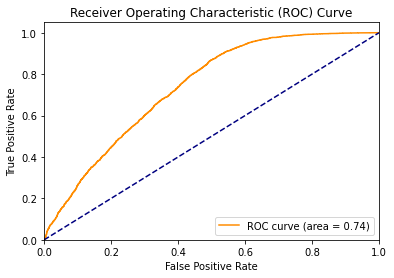

epoch 18
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.680190	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.642476	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.662821	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.674348	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Test Avg. Loss: 0.662639, Accuracy: 60.560000


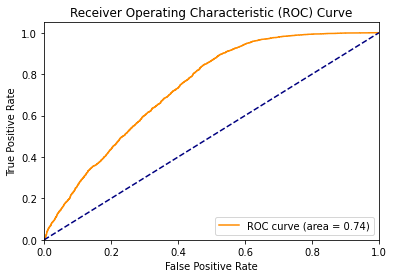

epoch 19
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.674823	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.621713	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.648992	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.640747	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.662473, Accuracy: 60.430000


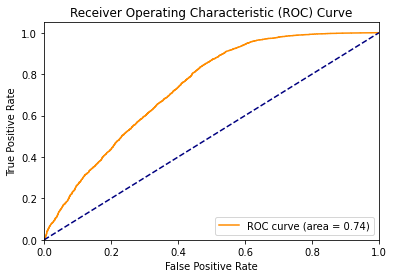

epoch 20
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.665714	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.689828	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.672496	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.688380	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.662556, Accuracy: 61.220000


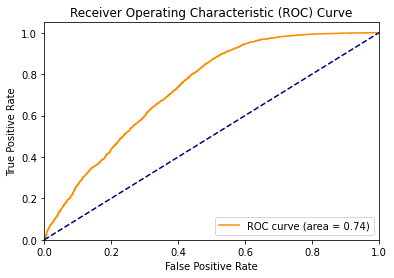

epoch 21
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.649472	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.642370	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.658093	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.686658	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.662242, Accuracy: 61.200000


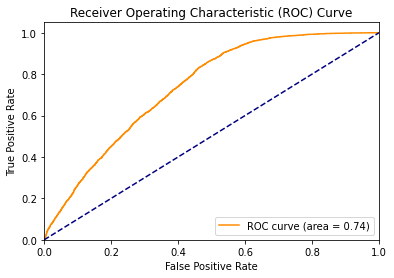

epoch 22
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.674465	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.638282	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.644151	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.659357	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.663377, Accuracy: 60.210000


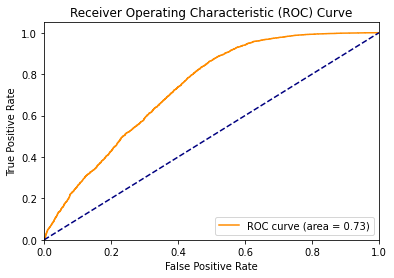

epoch 23
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.631970	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.677667	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.731831	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.643008	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.661858, Accuracy: 61.670000


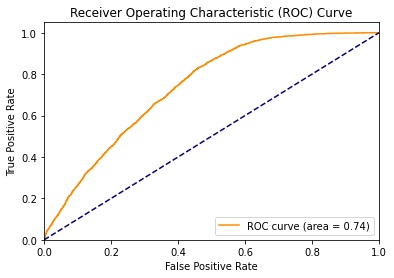

epoch 24
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.686520	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.679479	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.663709	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.664596	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.662228, Accuracy: 61.680000


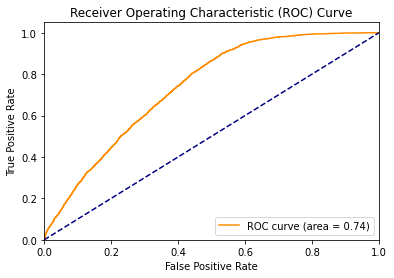

epoch 25
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.641928	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.656345	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.657977	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.648037	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.661685, Accuracy: 61.080000


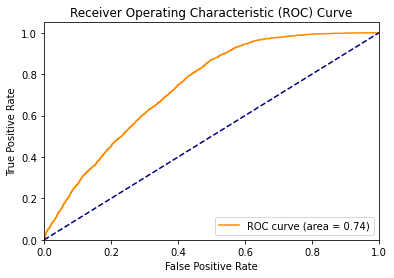

epoch 26
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.684028	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.667410	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.665362	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.654625	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.661792, Accuracy: 61.200000


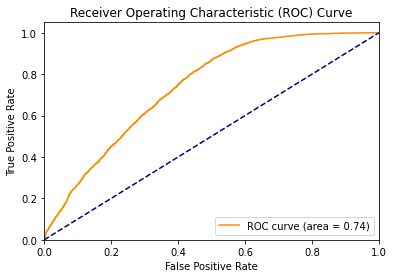

epoch 27
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.685293	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.681724	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.657421	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.651786	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.662070, Accuracy: 61.550000


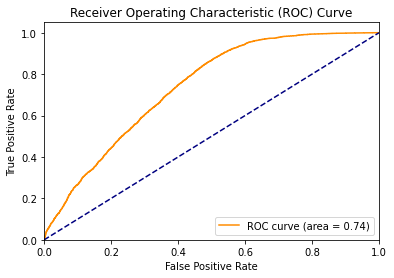

epoch 28
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.672786	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.658429	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.648623	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.621558	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Test Avg. Loss: 0.661655, Accuracy: 62.260000


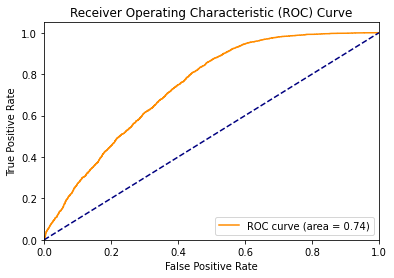

epoch 29
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.685493	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.690550	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.635402	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.627124	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.661417, Accuracy: 62.020000


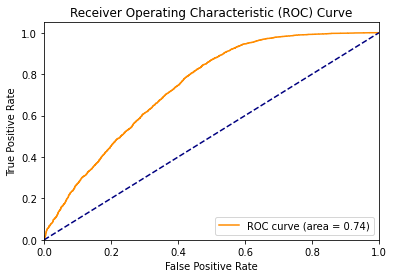

epoch 30
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.634499	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.628371	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.659119	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.674631	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.661744, Accuracy: 61.480000


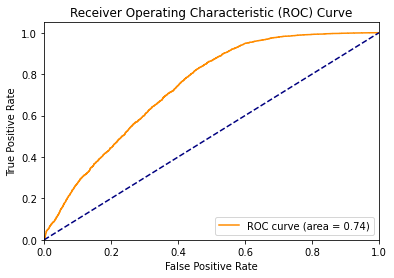

epoch 31
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.655193	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.664630	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.658255	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.645668	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.661650, Accuracy: 62.510000


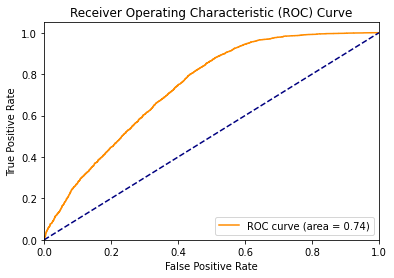

epoch 32
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.641242	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.660919	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.678298	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.630802	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.662045, Accuracy: 62.860000


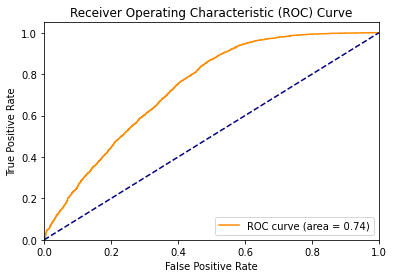

epoch 33
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.665052	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.685956	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.623732	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.643731	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.661301, Accuracy: 61.670000


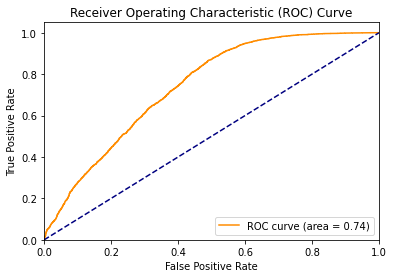

epoch 34
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.679619	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.639955	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.655143	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692308	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Test Avg. Loss: 0.661093, Accuracy: 62.120000


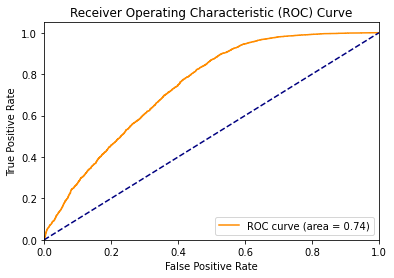

epoch 35
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.659799	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.658745	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.654144	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.682441	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.661636, Accuracy: 62.650000


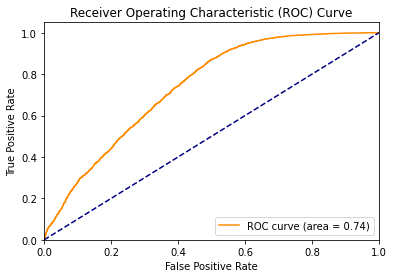

epoch 36
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.674344	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.650233	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692715	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.666407	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660901, Accuracy: 62.750000


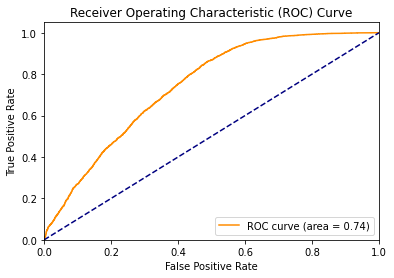

epoch 37
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.606070	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.668024	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.653500	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.670385	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.660827, Accuracy: 64.150000


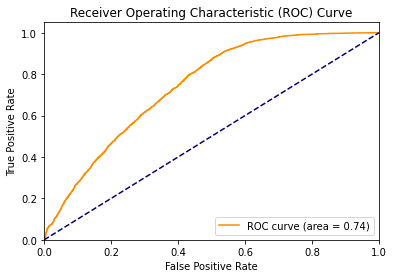

epoch 38
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.652467	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.626182	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.675852	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.670719	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.661409, Accuracy: 62.780000


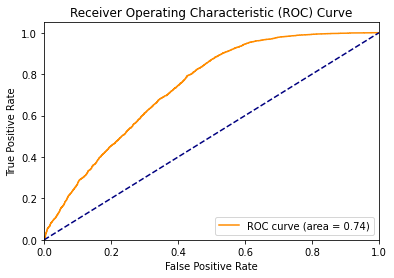

epoch 39
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.670443	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.632709	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.663656	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.641020	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.661295, Accuracy: 62.610000


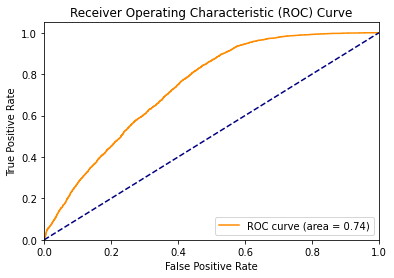

epoch 40
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.634230	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.627235	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.621996	 Precision attacker: 0.001900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.666540	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.660737, Accuracy: 63.300000


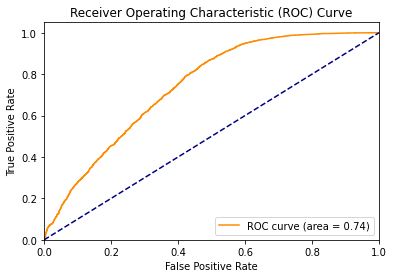

epoch 41
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.642107	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.686836	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.647092	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.666403	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.661177, Accuracy: 62.620000


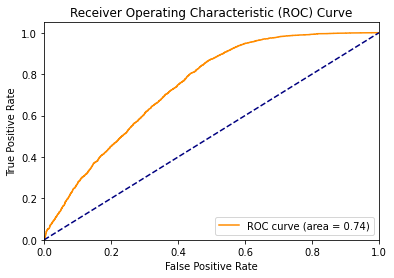

epoch 42
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.683144	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.707612	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.680588	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.671289	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.660250, Accuracy: 63.600000


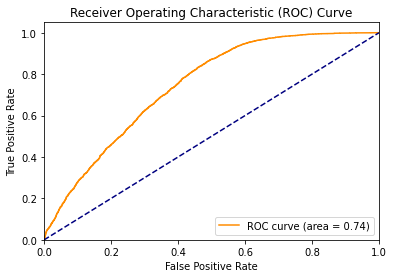

epoch 43
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.667545	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.668701	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.664382	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.667970	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.661222, Accuracy: 62.760000


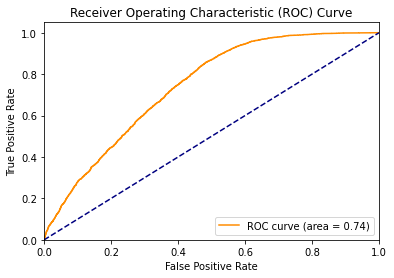

epoch 44
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.622600	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.636573	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.675071	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.683760	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.660687, Accuracy: 62.980000


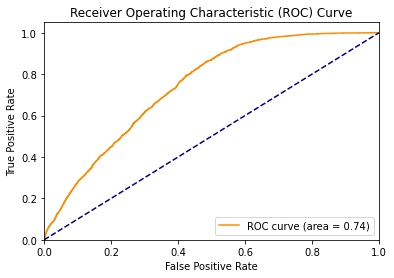

epoch 45
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.697373	 Precision attacker: 0.003150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.644094	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.623434	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.667380	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.660875, Accuracy: 63.070000


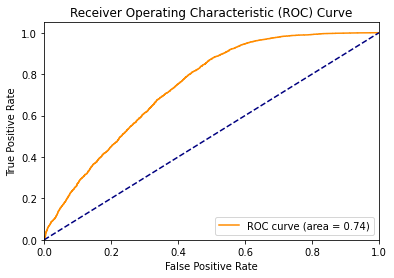

epoch 46
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.638676	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692613	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.682719	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.681032	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660487, Accuracy: 62.740000


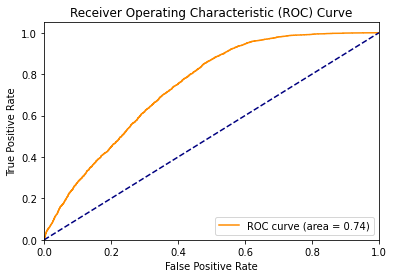

epoch 47
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.684965	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.688003	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.649211	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.655857	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.660537, Accuracy: 62.350000


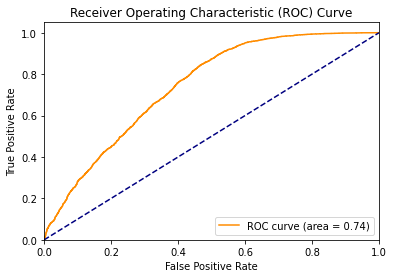

epoch 48
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.641425	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.650770	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693155	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.659369	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.660454, Accuracy: 63.470000


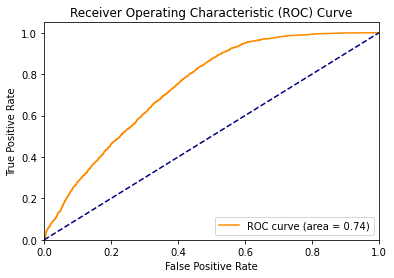

epoch 49
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.678505	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.640818	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.669213	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.666840	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.661083, Accuracy: 62.960000


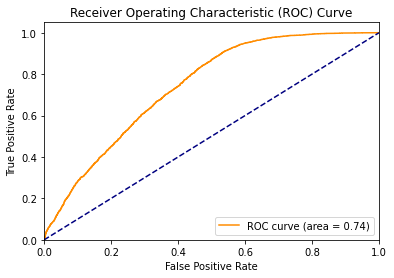

epoch 50
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.630011	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.617559	 Precision attacker: 0.001800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.678912	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.673107	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.661282, Accuracy: 62.750000


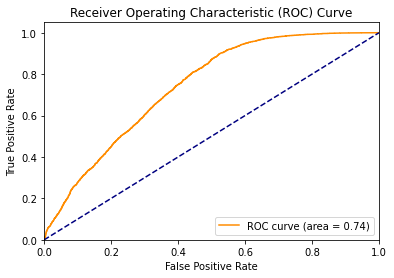

epoch 51
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.667900	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.659930	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.678841	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.642780	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.660578, Accuracy: 63.140000


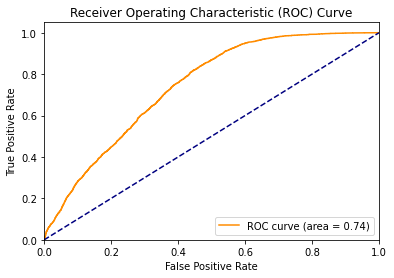

epoch 52
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.664502	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.651652	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.636703	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.632918	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.661778, Accuracy: 61.980000


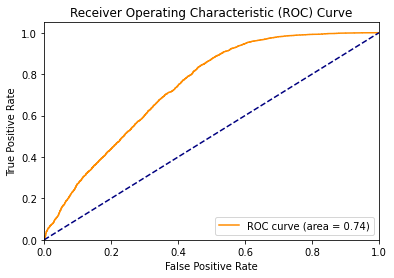

epoch 53
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.635838	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.632355	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.635634	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.659457	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.660345, Accuracy: 62.880000


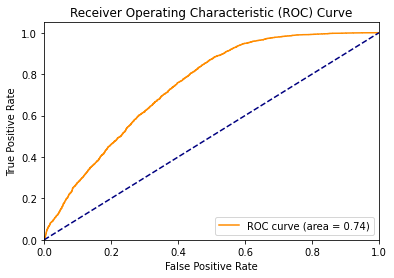

epoch 54
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.628654	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.660259	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.614423	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.666447	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.660613, Accuracy: 62.710000


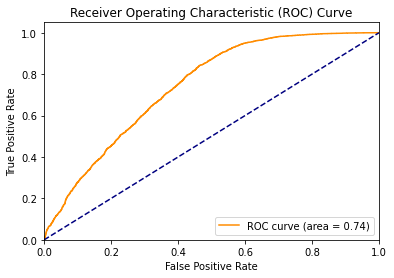

epoch 55
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.678888	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.661480	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.634957	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.624995	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Test Avg. Loss: 0.661267, Accuracy: 62.600000


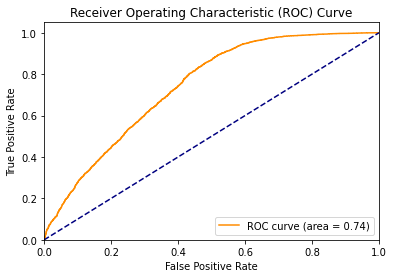

epoch 56
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.690546	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.658123	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.731279	 Precision attacker: 0.003150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.648816	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.661246, Accuracy: 63.560000


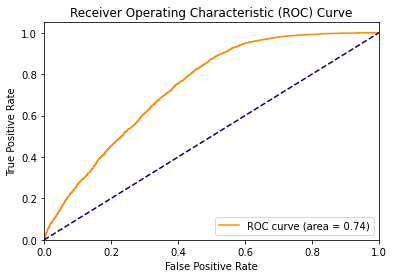

epoch 57
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.651779	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.707998	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.676710	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.659464	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660099, Accuracy: 63.760000


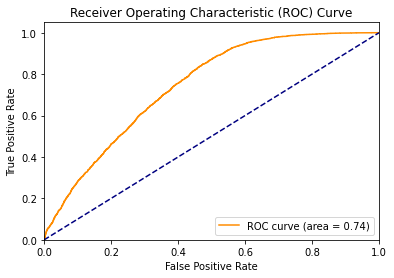

epoch 58
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.588407	 Precision attacker: 0.001600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.649023	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.646594	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.669662	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660561, Accuracy: 63.610000


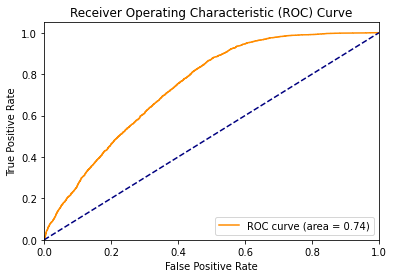

epoch 59
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.671704	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.664045	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.624139	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.642272	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.660436, Accuracy: 63.500000


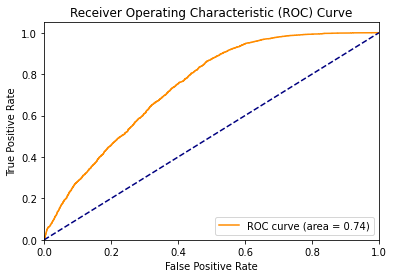

epoch 60
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.661604	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.655956	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.654648	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.634522	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.660867, Accuracy: 63.820000


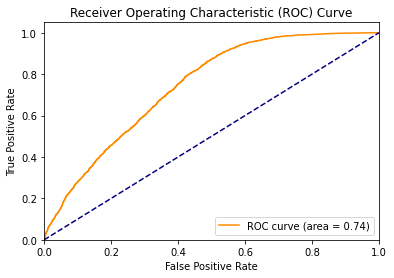

epoch 61
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.668831	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692800	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.680646	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.646592	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.660406, Accuracy: 63.060000


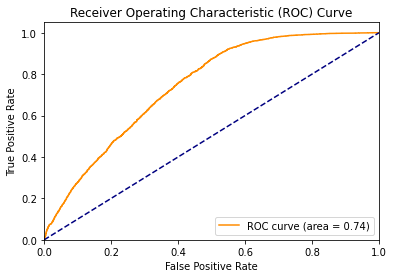

epoch 62
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.689361	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.614900	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.659708	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.699258	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Test Avg. Loss: 0.660466, Accuracy: 63.090000


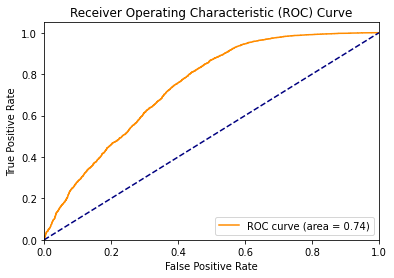

epoch 63
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.688983	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.668004	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.671738	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.622800	 Precision attacker: 0.001900	 recall attacler: 0.005000	
Test Avg. Loss: 0.660405, Accuracy: 62.630000


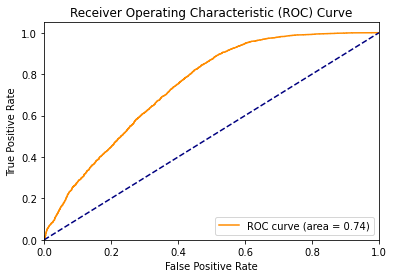

epoch 64
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.609478	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.672825	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.613923	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.658193	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.659519, Accuracy: 63.690000


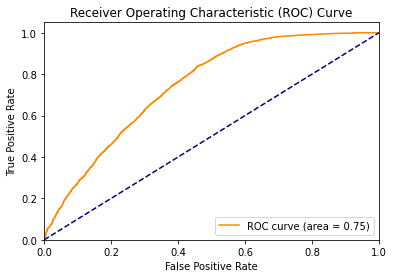

epoch 65
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.627812	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.641925	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.639902	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.683915	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.660837, Accuracy: 64.000000


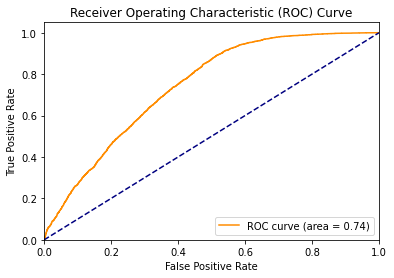

epoch 66
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.643358	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.688693	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.630599	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.627145	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Test Avg. Loss: 0.660690, Accuracy: 64.200000


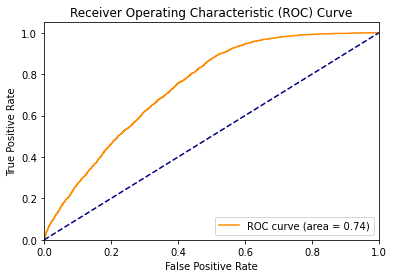

epoch 67
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.678333	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.648690	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.676485	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.675586	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660546, Accuracy: 63.530000


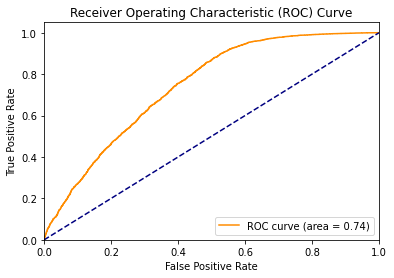

epoch 68
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.638143	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.686912	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.658177	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.688422	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.660593, Accuracy: 63.750000


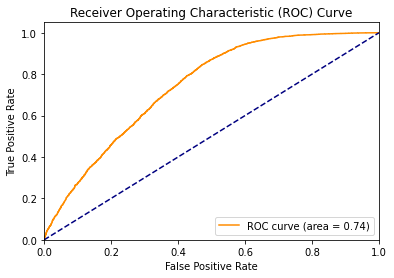

epoch 69
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.677698	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.704185	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.687849	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.617874	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.660669, Accuracy: 63.650000


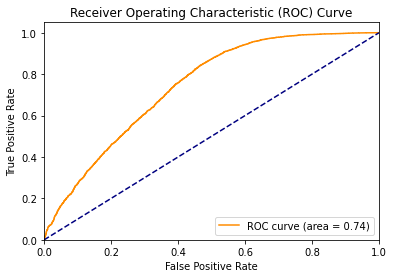

epoch 70
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.674233	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.665346	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.665758	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692265	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.659923, Accuracy: 64.400000


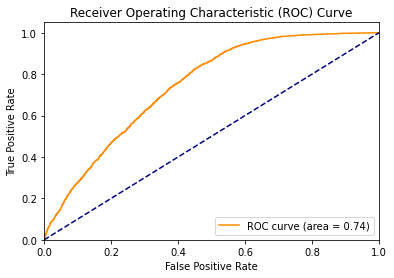

epoch 71
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.635981	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.612701	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.658991	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.713985	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Test Avg. Loss: 0.659757, Accuracy: 63.330000


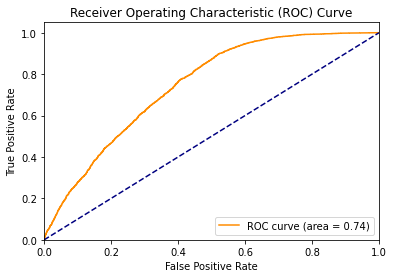

epoch 72
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.646520	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.656276	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.666497	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.642843	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Test Avg. Loss: 0.660601, Accuracy: 64.010000


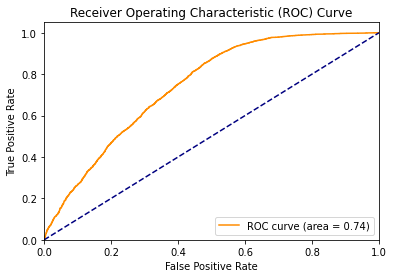

epoch 73
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.640072	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692067	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.636203	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.633717	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Test Avg. Loss: 0.660336, Accuracy: 64.000000


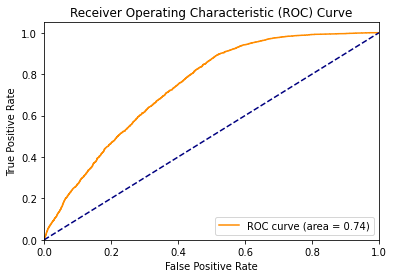

epoch 74
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.668761	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.678320	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.644952	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.687046	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.660186, Accuracy: 63.880000


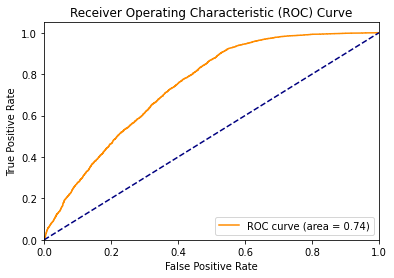

epoch 75
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.660928	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.644135	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.667090	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.689804	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660210, Accuracy: 64.000000


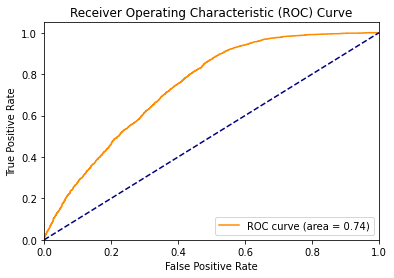

epoch 76
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.653337	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.652911	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.672453	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.646409	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660476, Accuracy: 64.160000


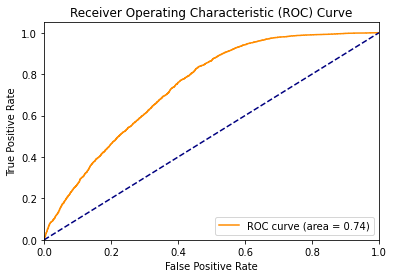

epoch 77
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.665710	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.653593	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.670872	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.663792	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.660858, Accuracy: 64.070000


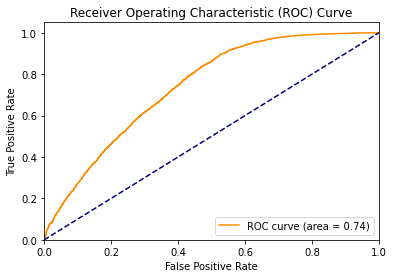

epoch 78
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.651224	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.673722	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.670983	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.677090	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.661024, Accuracy: 63.520000


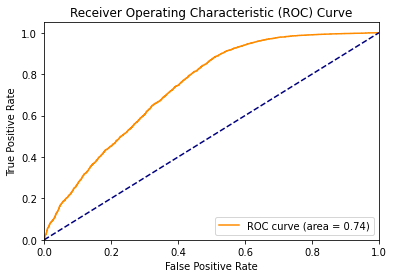

epoch 79
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.653624	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.647327	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.648903	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.629856	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.660489, Accuracy: 62.690000


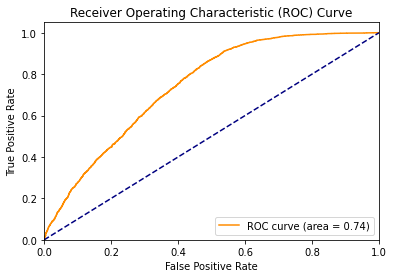

epoch 80
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.621025	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.674101	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.611472	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.704580	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Test Avg. Loss: 0.660399, Accuracy: 64.040000


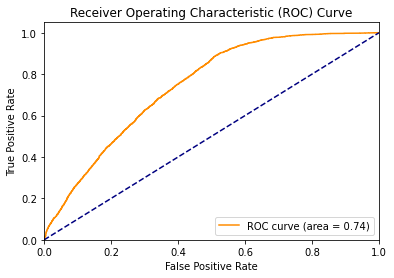

epoch 81
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.684164	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.646569	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.667408	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.614042	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.660434, Accuracy: 63.540000


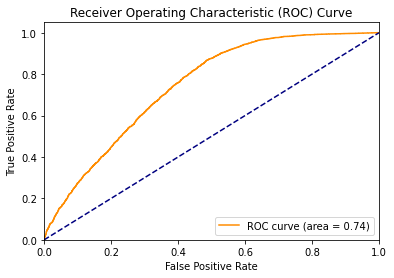

epoch 82
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.657468	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.662882	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.686014	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.651909	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.660823, Accuracy: 63.830000


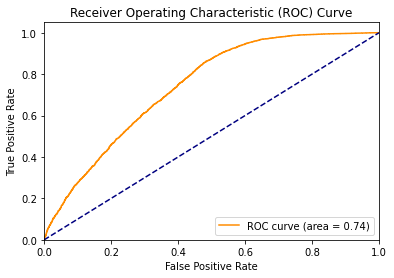

epoch 83
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692870	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.646741	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.659021	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.668640	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.659847, Accuracy: 63.990000


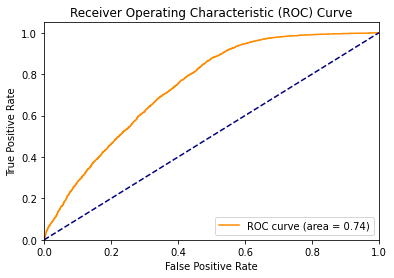

epoch 84
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.655075	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.695656	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.656748	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.670973	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.660167, Accuracy: 64.090000


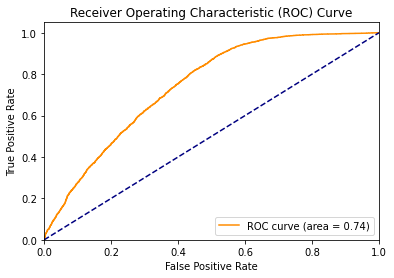

epoch 85
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.684630	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.662193	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.677085	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.655099	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.661435, Accuracy: 63.620000


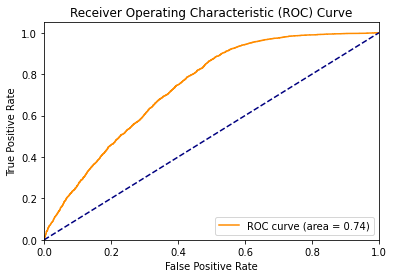

epoch 86
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.643705	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.681272	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691592	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.663006	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.661154, Accuracy: 63.770000


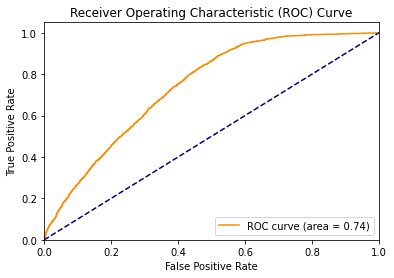

epoch 87
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.646917	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.650065	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.642502	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.650819	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.659899, Accuracy: 63.830000


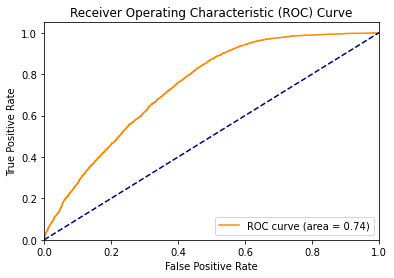

epoch 88
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.675376	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.610450	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.682837	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.601436	 Precision attacker: 0.001750	 recall attacler: 0.005000	
Test Avg. Loss: 0.660685, Accuracy: 64.430000


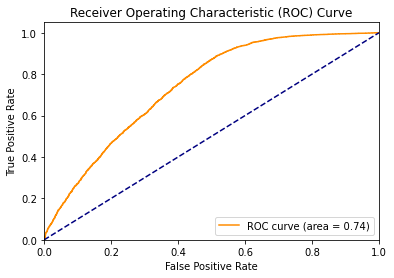

epoch 89
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.699027	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.685538	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.685913	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.669440	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.660224, Accuracy: 63.730000


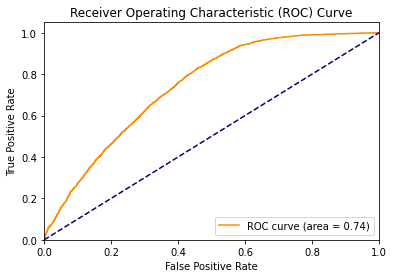

epoch 90
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.628682	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.624131	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.679608	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.659487	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.660168, Accuracy: 63.650000


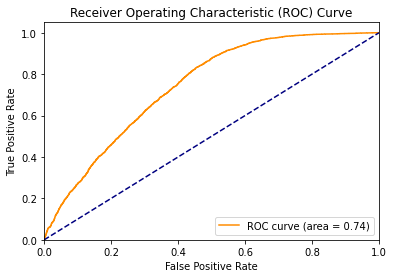

epoch 91
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.640835	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.619213	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.662598	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.658441	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.660934, Accuracy: 64.600000


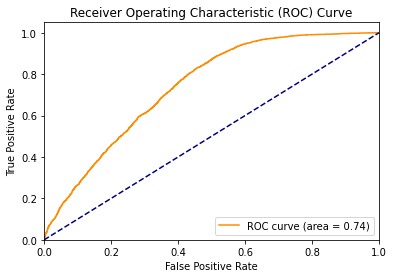

epoch 92
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.660470	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.655477	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.659225	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.669465	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.660753, Accuracy: 64.050000


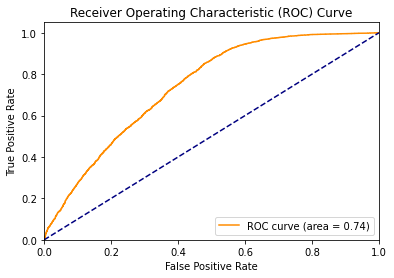

epoch 93
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.675889	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.660202	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.665469	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.653184	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.660104, Accuracy: 63.370000


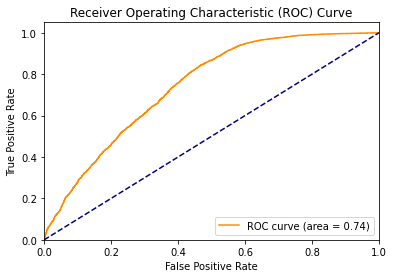

epoch 94
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.690835	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.636000	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.633542	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.640974	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.660920, Accuracy: 62.920000


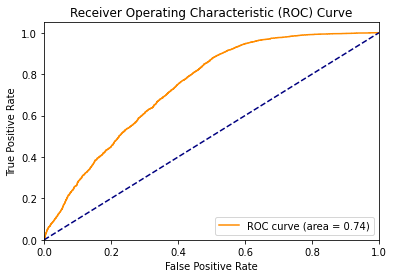

epoch 95
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.656878	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.696880	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.689769	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.660677	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.660218, Accuracy: 63.760000


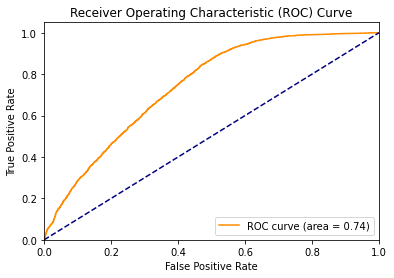

epoch 96
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.648907	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.675533	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.643539	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.614718	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.662024, Accuracy: 64.330000


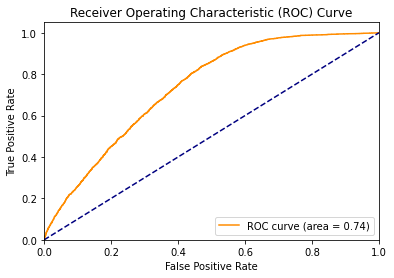

epoch 97
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.629804	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.635025	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.679842	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.626894	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.660149, Accuracy: 63.850000


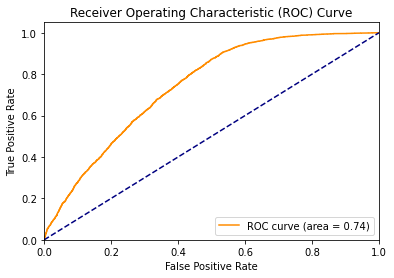

epoch 98
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.646952	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.682838	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.656918	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.629369	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.659782, Accuracy: 64.090000


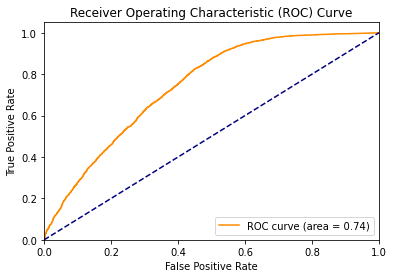

epoch 99
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.677367	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.625713	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.672137	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.649148	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.660214, Accuracy: 63.440000


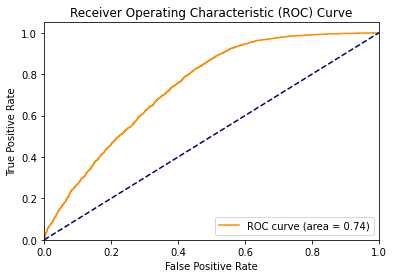

In [39]:
FE, INF = get_FE_INF()

Type of data: <class 'list'>
Length of data: 2
Type of data[1]: <class 'list'>


c:\Users\leily\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


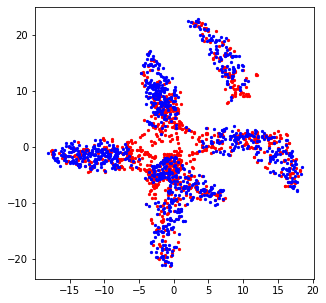

In [88]:
def extract_features(model, dataloader, device, num_batches=None):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if i == 0:
                print("Type of data:", type(data))
                print("Length of data:", len(data))
                print("Type of data[1]:", type(data[1]))
                if isinstance(data[1], tuple):
                    print("Length of data[1]:", len(data[1]))
                    print("Type of data[1][0]:", type(data[1][0]))
                    print("Shape of data[1][0]:", data[1][0].shape)
                    print("Type of data[1][1]:", type(data[1][1]))
                    print("Shape of data[1][1]:", data[1][1].shape)

            if num_batches and i >= num_batches:
                break
            
            # Assuming the structure is as expected
            inputs, (y1, y2) = data
            labels = torch.tensor(y2)  # Convert y2 to tensor
            
            inputs = inputs.to(device)
            features = model(inputs)
            features_flat = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features_flat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    features_array = np.vstack(features_list)
    labels_array = np.concatenate(labels_list)

    return features_array, labels_array


def plot_tsne_2d_attacker(reduced_features, labels):
    plt.figure(figsize=(5, 5))
    
    point_size = 5  # Adjust this value as needed
    
    # For non-member (label=0)
    plt.scatter(reduced_features[labels == 0, 0], 
               reduced_features[labels == 0, 1], 
               label='Non-Member', c='r', s=point_size)
    
    # For member (label=1)
    plt.scatter(reduced_features[labels == 1, 0], 
               reduced_features[labels == 1, 1], 
               label='Member', c='b', s=point_size)
    
   
    plt.show()
def plot_tsne_3d_attacker(reduced_features, labels):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    point_size = 5  # Adjust this value as needed
    
    # For non-member (label=0)
    ax.scatter(reduced_features[labels == 0, 0], 
               reduced_features[labels == 0, 1], 
               reduced_features[labels == 0, 2], 
               label='Non-Member', c='r', s=point_size)
    
    # For member (label=1)
    ax.scatter(reduced_features[labels == 1, 0], 
               reduced_features[labels == 1, 1], 
               reduced_features[labels == 1, 2], 
               label='Member', c='b', s=point_size)
    

    
    plt.show()



FE = torch.load(fe_model_file)
num_batches = 20
features, labels = extract_features(FE, atk_test_dl, device, num_batches)
reduced_features = apply_tsne(features)
plot_tsne_2d_attacker(reduced_features, labels)


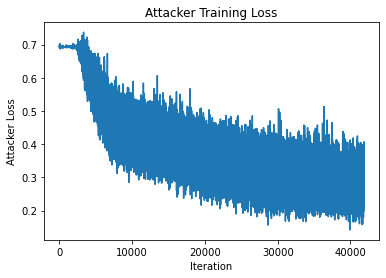

In [242]:
#plotting attacker loss during training 
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Attacker Loss')
plt.title('Attacker Training Loss')
plt.show()

In [94]:
criterion = nn.CrossEntropyLoss().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()

def train(FE_model,INF_model, CF_model, trainloader, current_lr,current_lr_atk,tradoff=1):
    FE_model.train()
    INF_model.train()
    CF_model.train()
    
    
    FE_optimizer = optim.Adam(FE_model.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF_model.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF_model.parameters(), lr=current_lr_atk, weight_decay=1e-4)
    
    for i, (images, (labels, privlabels)) in enumerate(trainloader):
        if torch.cuda.is_available():
            images, labels, privlabels = images.cuda(), labels.cuda(), privlabels.cuda()

        # get features from the feature extractor
        features = FE_model(images)
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())

        # feed only private images==1 to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        
        # compute loss and backprop
        loss = -tradoff * loss_INF + (1. - tradoff) * loss_CF
        
        FE_optimizer.zero_grad()
        loss.backward()
        FE_optimizer.step()

        
         # get features from the feature extractor
        features = FE_model(images).detach()
        INF_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())
        loss_INF.backward()
        INF_optimizer.step()

       
        # feed only private images to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        loss_CF.backward()
        CF_optimizer.step()

        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\tLoss Attacker: {:.6f}'.format(
                i, i * len(images), len(trainloader.dataset),
                100. * i / len(trainloader), loss_CF.item(), loss_INF.item()))

    return FE_model, INF_model, CF_model       

In [40]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet-0.75')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file_defense = os.path.join(save_dir, 'FE_defense.pth')
cf_model_file_defense = os.path.join(save_dir, 'CF_defense.pth')
inf_model_file_defense = os.path.join(save_dir, 'INF_defense.pth')

In [96]:
total_epoch=300
lr=0.0001
lr_atk=3e-3
tradoff=0.75
def get_FE_defense():
    #using FE and CF after pretraining them
    FE = torch.load(fe_model_file)
    #FE=AlexNet_FE()
    #CF=AlexNet_predictor()
    CF = torch.load(cf_model_file)
    INF=torch.load(inf_model_file)
    #INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF = CF.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            current_lr_atk = adjust_learning_rate(epoch,lr_atk)
            FE, INF, CF =train(FE,INF, CF, atk_train_dl, current_lr,current_lr_atk, tradoff)
            #test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "FE_defense.pth")
        torch.save(CF.module, "CF_defense.pth")
        torch.save(INF.module, "INF_defense.pth")
    else:
        torch.save(FE,fe_model_file_defense)
        torch.save(INF,inf_model_file_defense)
        torch.save(CF, cf_model_file_defense)
    return FE

In [97]:
FE=get_FE_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.070119	Loss Attacker: 0.716275
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.343749	Loss Attacker: 0.691653
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.519538	Loss Attacker: 0.690087
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.933576	Loss Attacker: 0.692355
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.953508	Loss Attacker: 0.696143
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.879147	Loss Attacker: 0.693374
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 1.067052	Loss Attacker: 0.693170
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.489249	Loss Attacker: 0.693294
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.538183	Loss Attacker: 0.693759
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.936921	Loss Attacker: 0.693240
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 1.533477	Loss Attacker: 0.693486
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 1.438255	Loss Attacker: 0.693268
epoch 3
Epoch: 0 [0/50000

In [47]:
#train attacker after applying our defense
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_attacker_defense(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(data_train_loader):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)

        features = FE(X)
        # feed them to the inf model
        pred_private_labels = INF(features)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  INF

In [48]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_attacker_defense(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #total_samples = 0
    predicted_scores_test=[]
    true_labels_test=[]

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
            features = FE(X)
            output = INF_model(features)
            predicted_scores_test.extend(output.squeeze().detach().cpu().numpy())
            true_labels_test.extend(y2.cpu().numpy())
            #print(output)
            y2= y2.unsqueeze(1)
            #print(y2)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            #total_samples +=X.shape[0]
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)
    fpr, tpr, _ = roc_curve(true_labels_test, predicted_scores_test)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [52]:
fe_model_file_defense = "C:\\Users\\leily\\OneDrive\\Desktop\\membership\\resnet-0.75\\FE_defense.pth"
inf_model_file = "C:\\Users\\leily\\OneDrive\\Desktop\\membership\\resnet-0.75\\INF_defense.pth"


In [53]:
total_epoch=100
lr=0.000003
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_INF_defense():
    FE = torch.load(fe_model_file_defense)
    INF=torch.load(inf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch,lr)
            INF = train_attacker_defense(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass

    return FE,INF

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693882	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693520	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692979	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693285	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


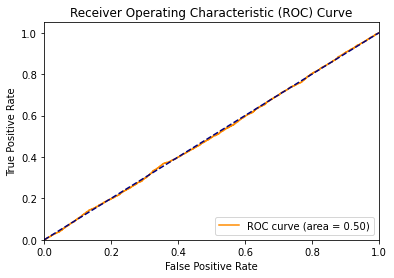

epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692879	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692924	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692748	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693312	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


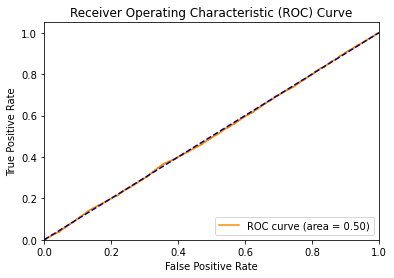

epoch 2
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691222	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693131	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.695697	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692175	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


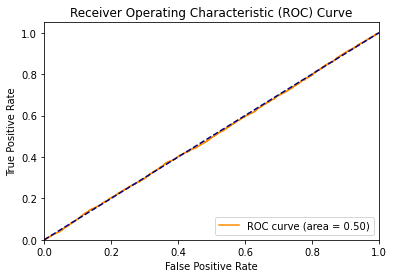

epoch 3
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693294	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694264	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693498	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693180	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


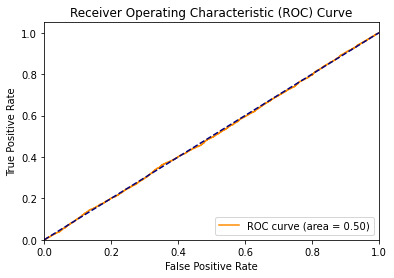

epoch 4
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693994	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692205	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692033	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694440	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


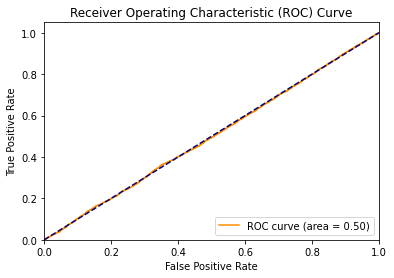

epoch 5
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691484	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693638	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693796	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691412	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


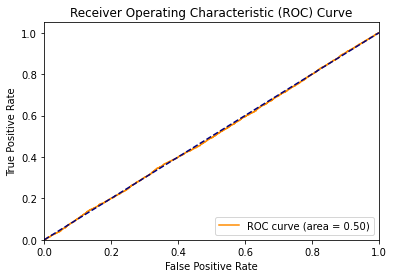

epoch 6
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692661	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693383	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692835	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693475	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


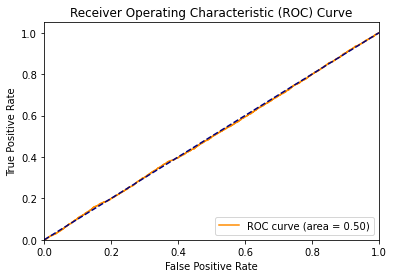

epoch 7
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693213	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692911	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693683	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692990	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


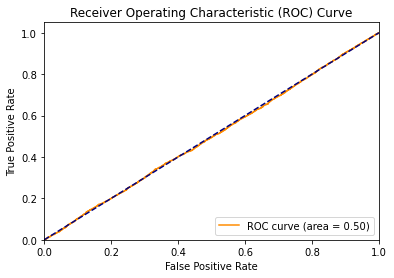

epoch 8
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693803	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692917	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693208	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694865	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


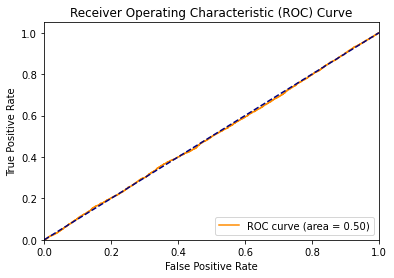

epoch 9
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692498	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693104	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693149	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692731	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


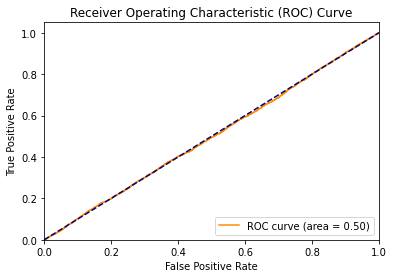

epoch 10
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691890	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692735	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693425	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691965	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


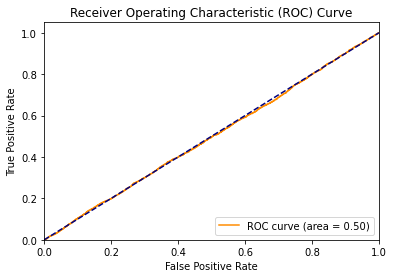

epoch 11
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692341	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692124	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694192	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693125	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.693199, Accuracy: 50.000000


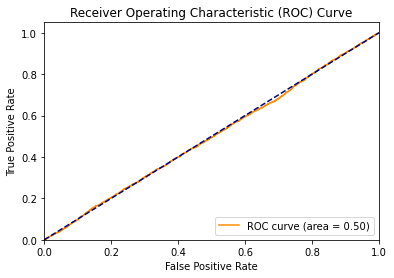

epoch 12
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693495	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.691730	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692934	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693508	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


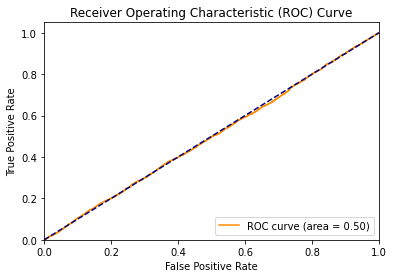

epoch 13
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692696	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693982	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691263	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693580	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


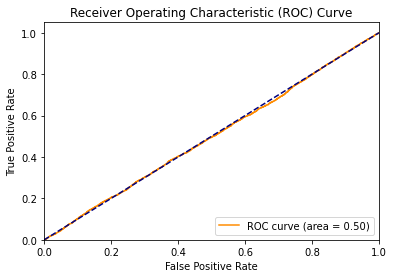

epoch 14
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692866	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694481	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692956	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694695	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


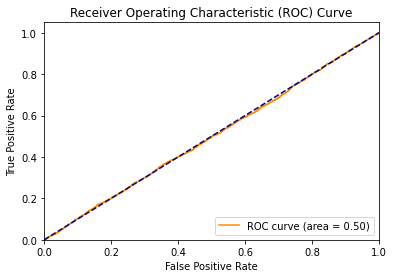

epoch 15
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693139	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693737	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692906	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694174	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


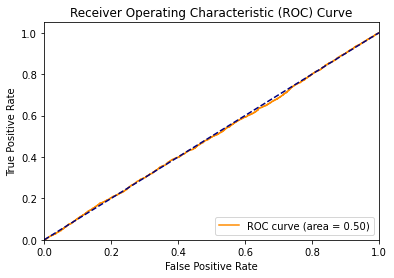

epoch 16
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694603	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693887	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693372	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693073	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


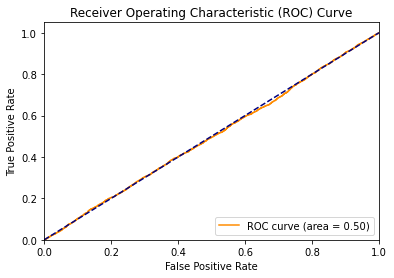

epoch 17
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692243	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694542	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694044	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693044	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


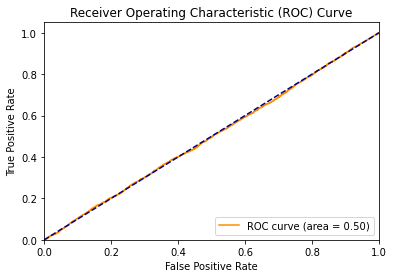

epoch 18
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694819	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693311	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693159	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693293	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


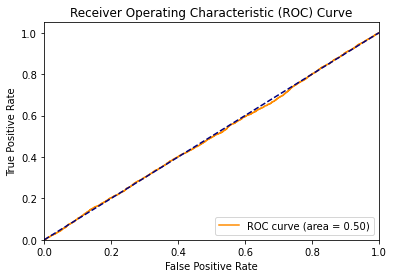

epoch 19
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694800	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693223	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694123	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692309	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


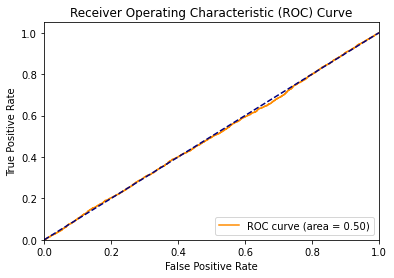

epoch 20
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692297	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693327	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694283	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692926	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


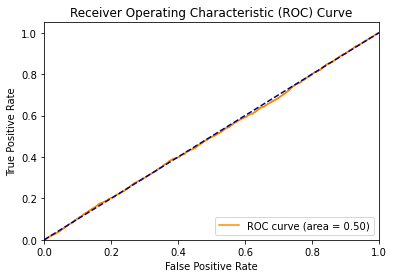

epoch 21
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692808	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693643	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693214	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693726	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


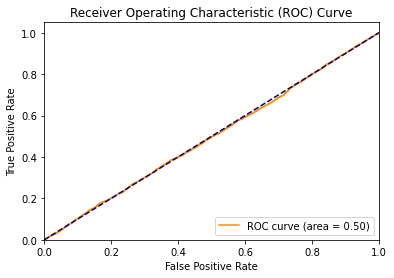

epoch 22
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691682	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694676	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693900	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693654	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


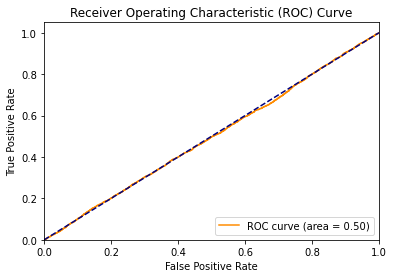

epoch 23
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691834	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692115	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693858	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694933	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


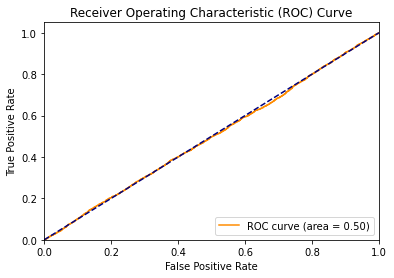

epoch 24
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693036	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692467	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694412	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693723	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


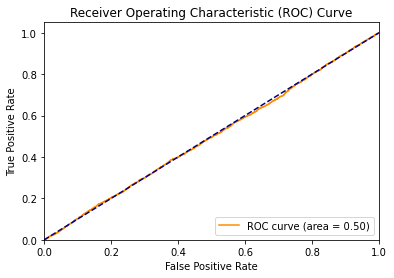

epoch 25
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693577	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693184	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693419	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693013	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


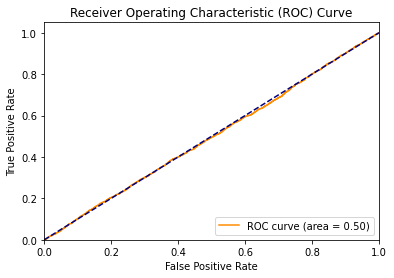

epoch 26
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691821	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693407	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692546	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694042	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


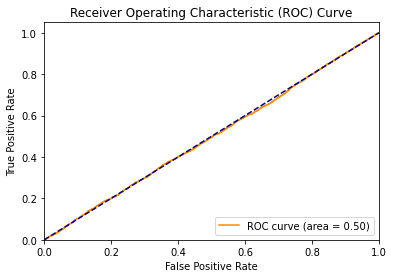

epoch 27
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693994	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693913	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692516	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693552	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


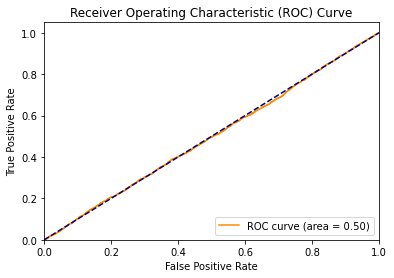

epoch 28
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694407	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694252	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694611	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693097	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


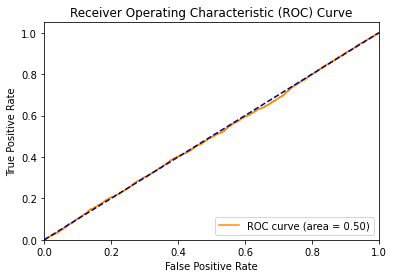

epoch 29
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693094	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693348	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692834	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.695013	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


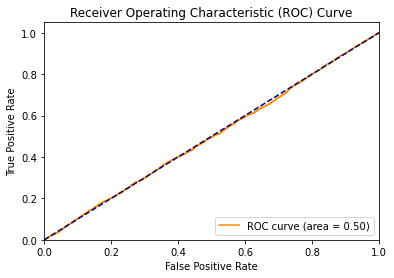

epoch 30
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693812	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692084	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693389	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694106	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


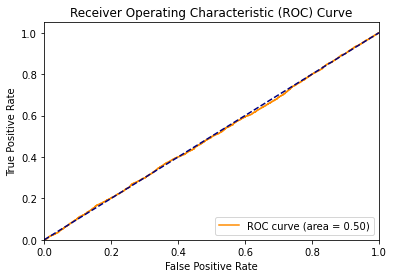

epoch 31
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692598	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.695212	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693468	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694238	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.693200, Accuracy: 50.000000


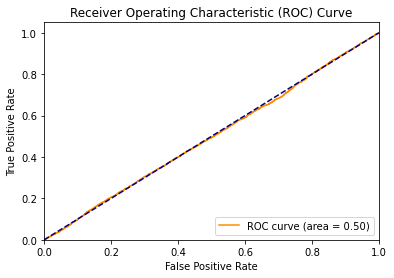

epoch 32
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692805	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.690836	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693043	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693610	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


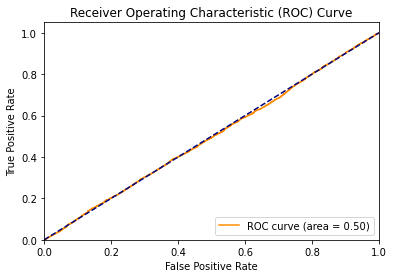

epoch 33
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692347	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.695307	 Precision attacker: 0.003200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692579	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691784	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.693184, Accuracy: 50.000000


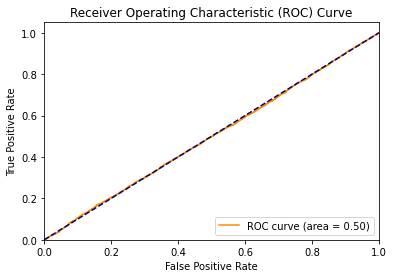

epoch 34
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694123	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693017	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692303	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692186	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


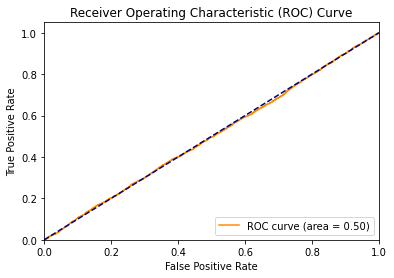

epoch 35
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692032	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693249	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692458	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694362	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.693196, Accuracy: 50.000000


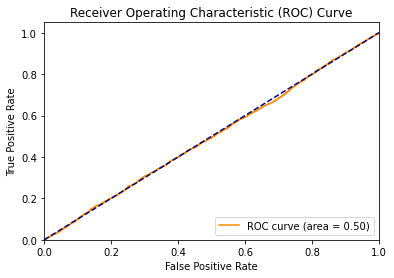

epoch 36
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692238	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692836	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693475	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692690	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


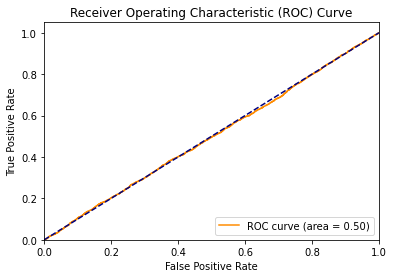

epoch 37
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694367	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692515	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692912	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692851	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


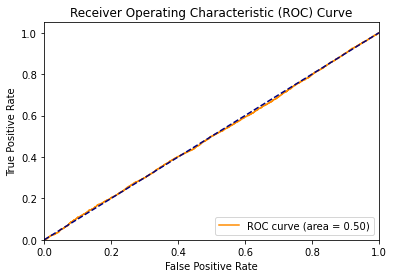

epoch 38
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693748	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692450	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693056	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692144	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


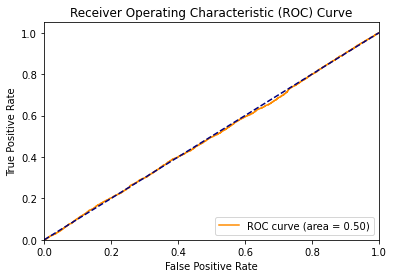

epoch 39
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693374	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692103	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692754	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691526	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


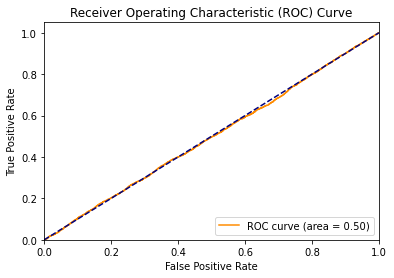

epoch 40
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694487	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693034	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694338	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692232	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


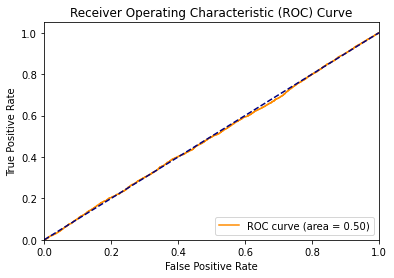

epoch 41
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693356	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692232	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693159	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692621	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693183, Accuracy: 50.000000


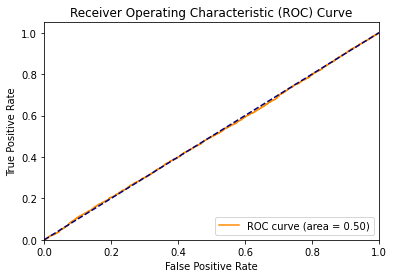

epoch 42
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693937	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693241	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692668	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693064	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


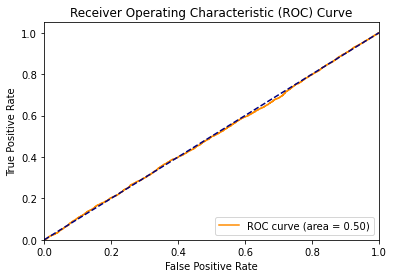

epoch 43
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693283	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.691365	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693706	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692095	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


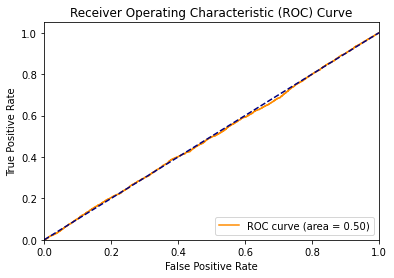

epoch 44
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693510	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692015	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693183	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693158	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


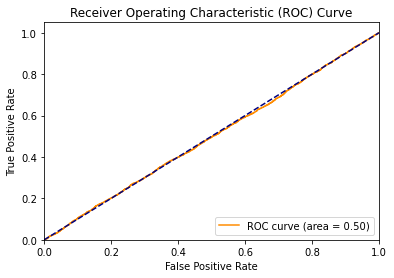

epoch 45
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693453	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692119	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693681	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693010	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


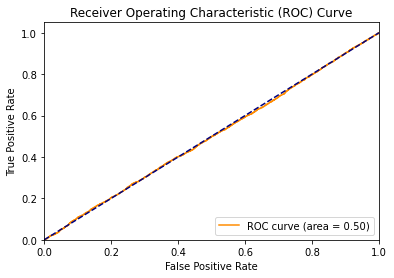

epoch 46
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691665	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.695145	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694386	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692737	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


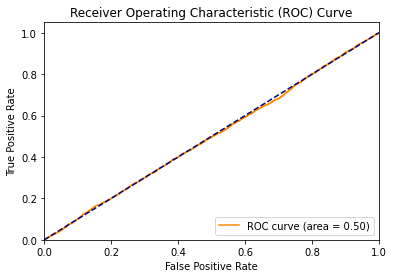

epoch 47
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692705	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693026	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691827	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693011	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


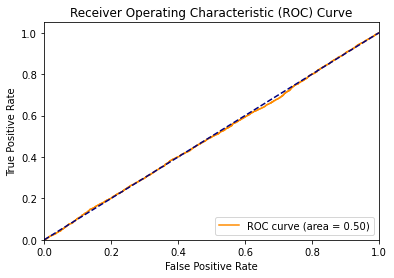

epoch 48
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692186	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694726	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692866	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694411	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


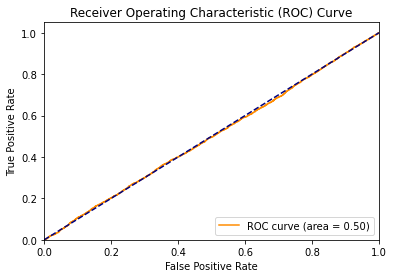

epoch 49
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693322	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693049	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693902	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692546	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


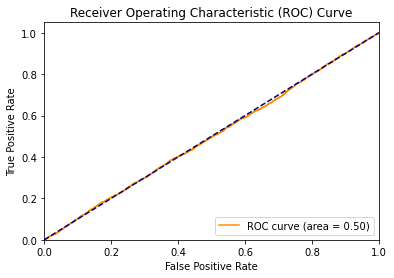

epoch 50
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693591	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692501	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692602	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694054	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.693196, Accuracy: 50.000000


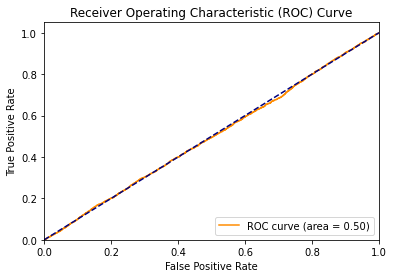

epoch 51
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.695506	 Precision attacker: 0.003150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694903	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691678	 Precision attacker: 0.001900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693073	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


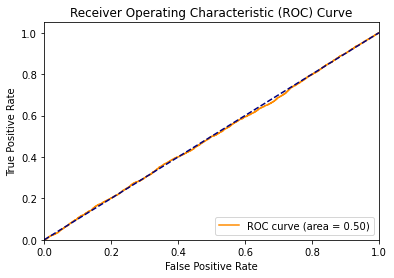

epoch 52
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692800	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692272	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.695266	 Precision attacker: 0.003150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693407	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


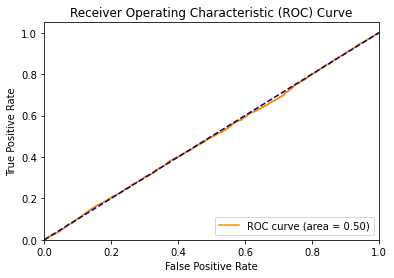

epoch 53
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694867	 Precision attacker: 0.003000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693434	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693413	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692069	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


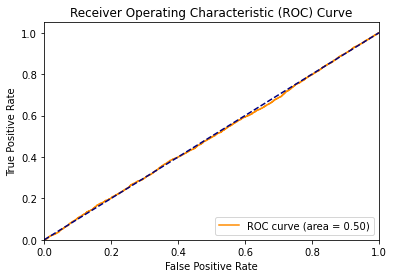

epoch 54
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694082	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692471	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692369	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693833	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


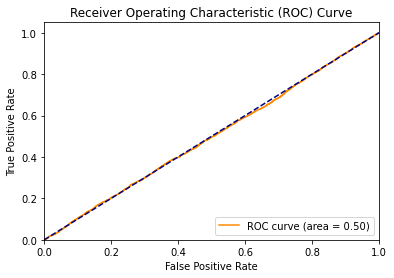

epoch 55
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693332	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694008	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692863	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692696	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


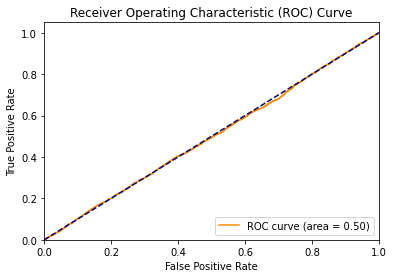

epoch 56
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691820	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693429	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693468	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692543	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.693186, Accuracy: 50.000000


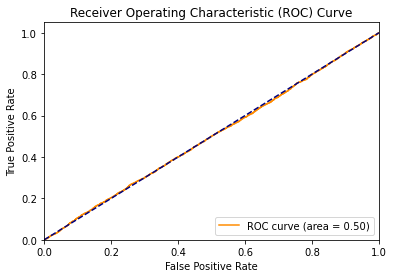

epoch 57
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693452	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692586	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692732	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694100	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


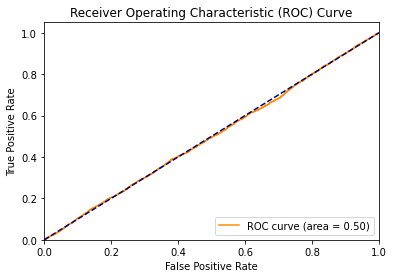

epoch 58
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.695294	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692631	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694073	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693366	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


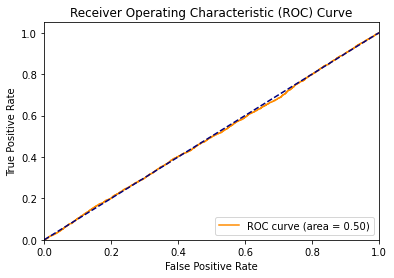

epoch 59
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692533	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692155	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693742	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693874	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


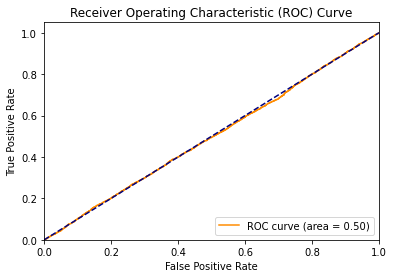

epoch 60
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691421	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693193	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692849	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694257	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


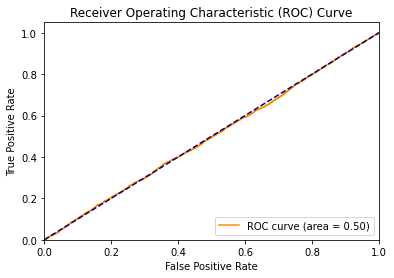

epoch 61
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692690	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693358	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693701	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691906	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


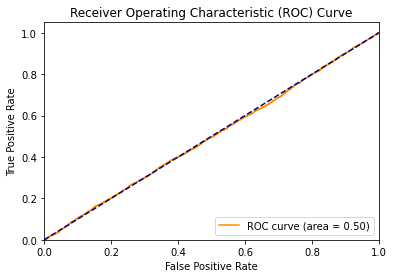

epoch 62
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692120	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694748	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692977	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693209	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


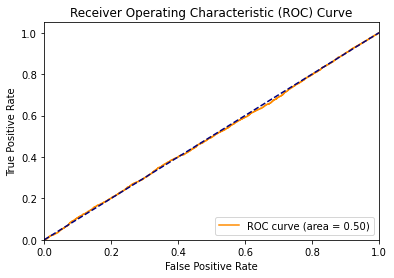

epoch 63
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692183	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693588	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692670	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694154	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


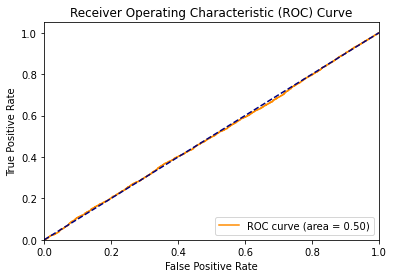

epoch 64
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693058	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694360	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694792	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693447	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


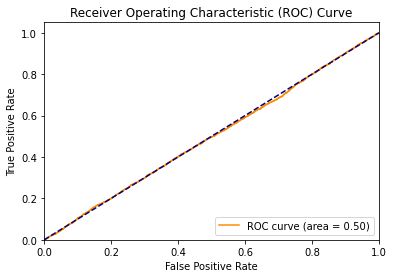

epoch 65
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693166	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.691990	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694133	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692324	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


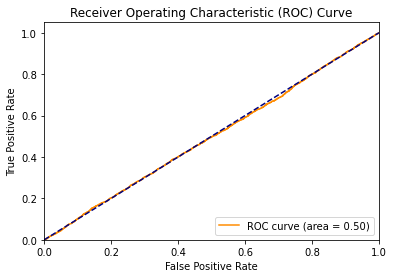

epoch 66
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692539	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693210	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691213	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693703	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


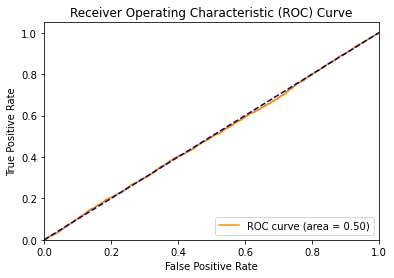

epoch 67
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693386	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693113	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693460	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.691776	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


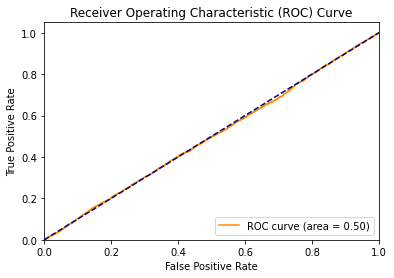

epoch 68
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691486	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693289	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693454	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693130	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


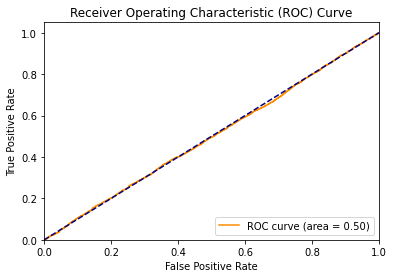

epoch 69
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693449	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692785	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692441	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692462	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.693184, Accuracy: 50.000000


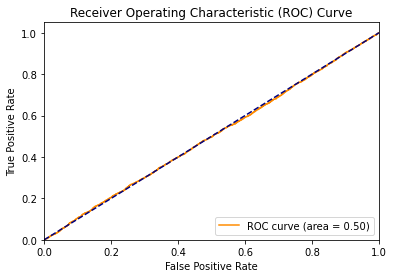

epoch 70
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693252	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692333	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693813	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693345	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


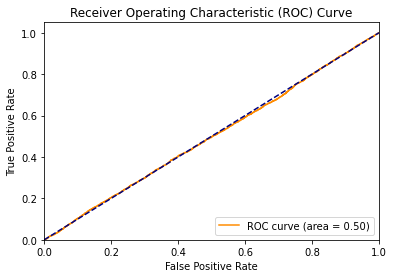

epoch 71
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692880	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694319	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692679	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694444	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


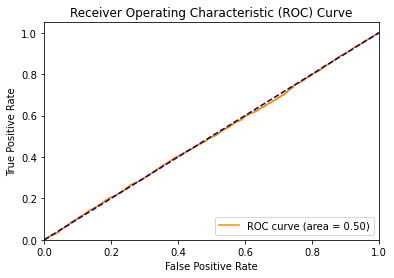

epoch 72
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692490	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692785	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692810	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693025	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


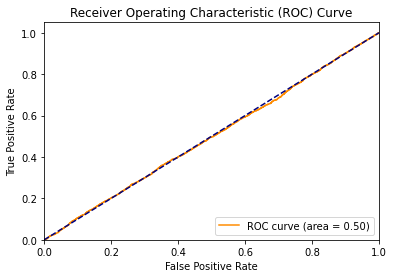

epoch 73
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693055	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693102	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692445	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692134	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


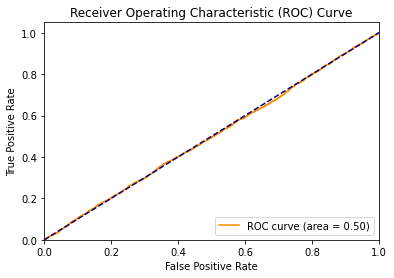

epoch 74
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.690957	 Precision attacker: 0.002050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692355	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693679	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.695068	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


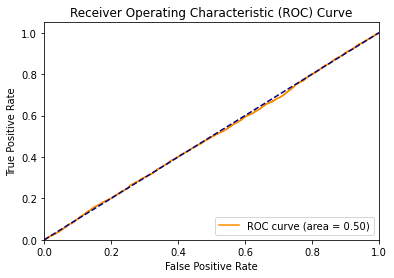

epoch 75
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.690803	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693092	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692539	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693490	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


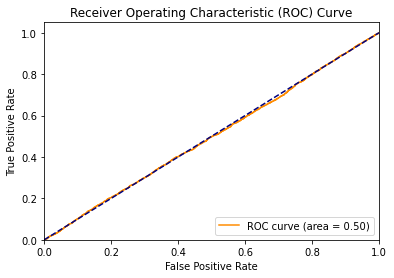

epoch 76
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693081	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694521	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693661	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693273	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


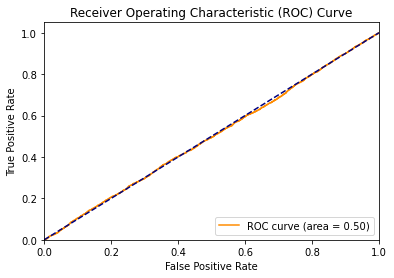

epoch 77
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.695175	 Precision attacker: 0.003050	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692067	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691986	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692787	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.693197, Accuracy: 50.000000


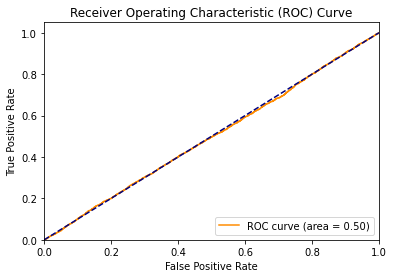

epoch 78
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692282	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694170	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692573	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692230	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


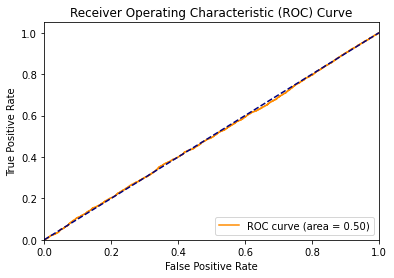

epoch 79
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692646	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693887	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693792	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693289	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


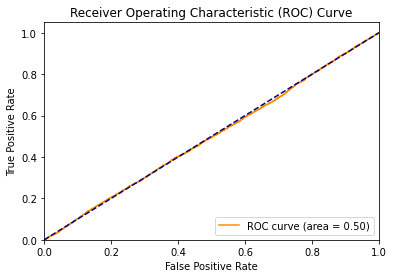

epoch 80
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691343	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692878	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692940	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694012	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


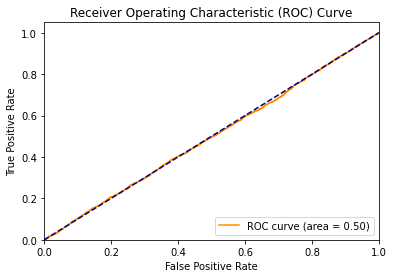

epoch 81
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.694694	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694849	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692801	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693771	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693186, Accuracy: 50.000000


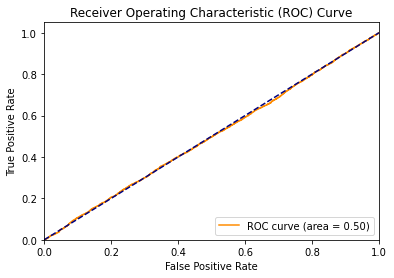

epoch 82
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693777	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.691889	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693053	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693337	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


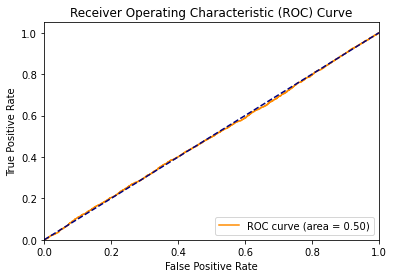

epoch 83
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691969	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.690750	 Precision attacker: 0.001800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693097	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692828	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.693194, Accuracy: 50.000000


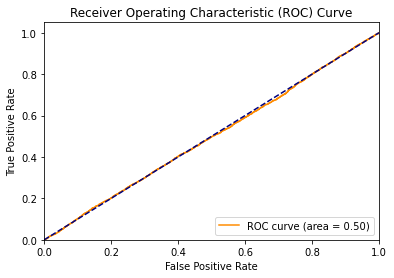

epoch 84
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693976	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692841	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692976	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694341	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


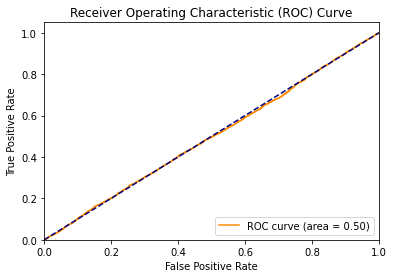

epoch 85
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692424	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693057	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691163	 Precision attacker: 0.001850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693575	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693189, Accuracy: 50.000000


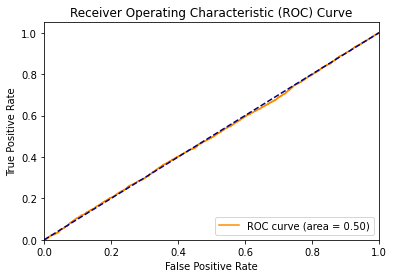

epoch 86
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693742	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692786	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692162	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693416	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


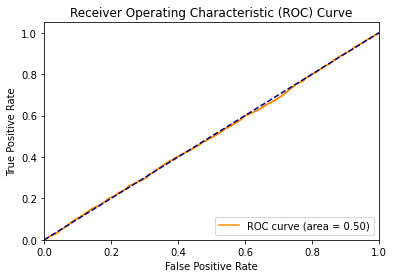

epoch 87
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693329	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693617	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693676	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693137	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


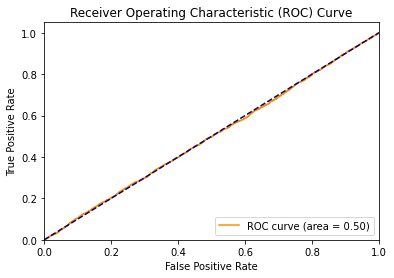

epoch 88
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693416	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692569	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.695379	 Precision attacker: 0.003200	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692028	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Test Avg. Loss: 0.693191, Accuracy: 50.000000


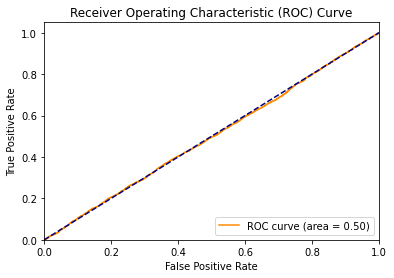

epoch 89
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692347	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692590	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692254	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693991	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


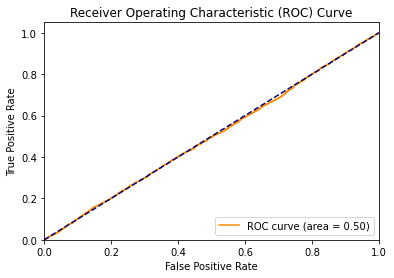

epoch 90
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692613	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693391	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693084	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.690677	 Precision attacker: 0.001650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


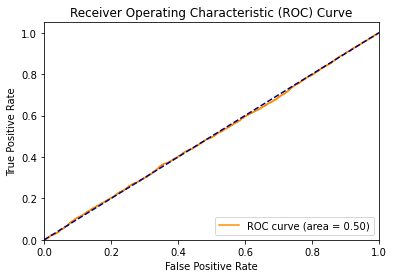

epoch 91
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691626	 Precision attacker: 0.002000	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693757	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691905	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693009	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


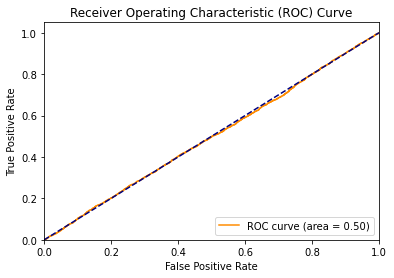

epoch 92
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693072	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694088	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693681	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.694302	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693193, Accuracy: 50.000000


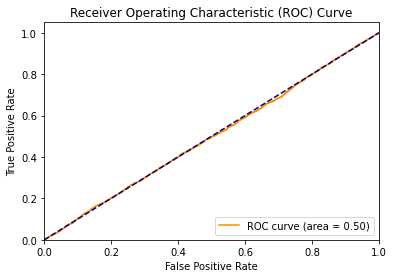

epoch 93
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692218	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.691680	 Precision attacker: 0.002100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.692706	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693044	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Test Avg. Loss: 0.693195, Accuracy: 50.000000


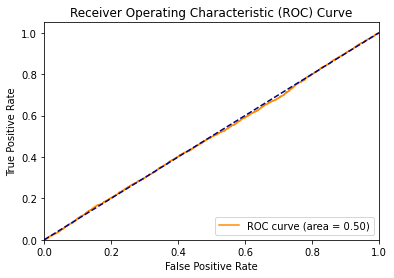

epoch 94
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692756	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692881	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.691935	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692662	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


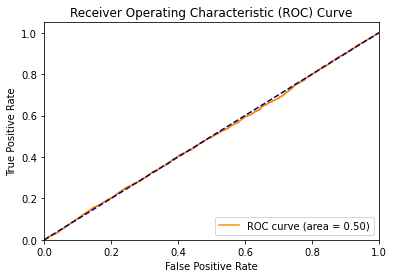

epoch 95
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.693759	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693126	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693561	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693197	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.693188, Accuracy: 50.000000


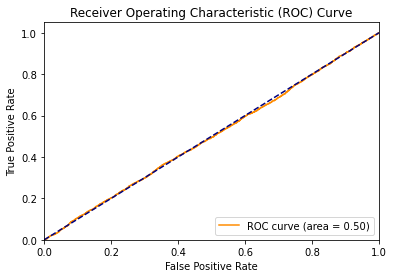

epoch 96
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692474	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.693080	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694191	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693431	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693190, Accuracy: 50.000000


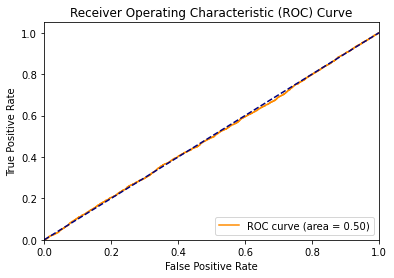

epoch 97
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.691945	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694632	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694360	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.693854	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Test Avg. Loss: 0.693187, Accuracy: 50.000000


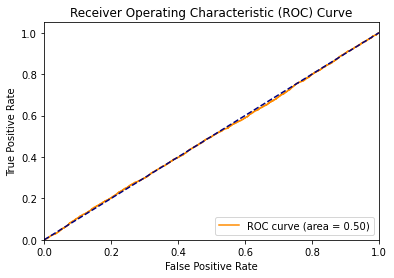

epoch 98
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692423	 Precision attacker: 0.002200	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692948	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.694409	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692973	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.693192, Accuracy: 50.000000


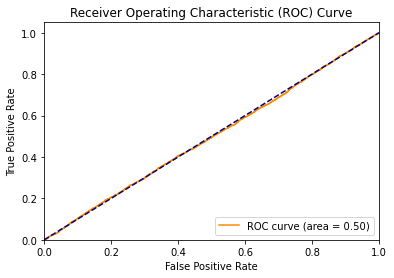

epoch 99
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.692860	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.692996	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.693210	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.692115	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.693196, Accuracy: 50.000000


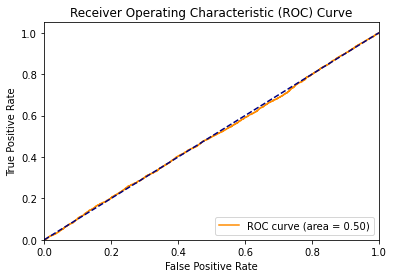

In [54]:
FE,INF = get_INF_defense()

Type of data: <class 'list'>
Length of data: 2
Type of data[1]: <class 'list'>


c:\Users\leily\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


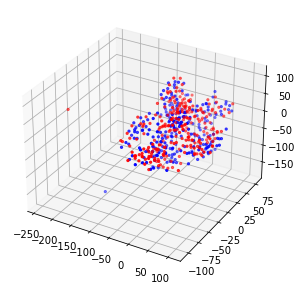

In [93]:
FE = torch.load(fe_model_file_defense)
num_batches = 5
features, labels = extract_features(FE, atk_test_dl, device, num_batches)
reduced_features = apply_tsne(features)
plot_tsne_3d_attacker(reduced_features, labels)

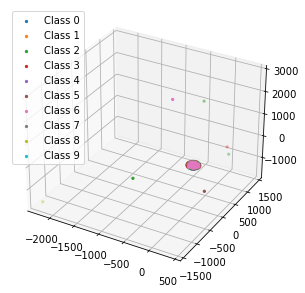

In [102]:
FE = torch.load(fe_model_file_defense)
num_batches = 20
features, labels = extract_features(FE, clf_test_dl, device, num_batches)
reduced_features = apply_tsne(features)
plot_tsne_3d(reduced_features, labels)

In [89]:
#train classifier after applying our defense
clf_criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_classifier_defense(FE, CF, data_train_loader, current_lr,device, vis=None):
    CF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, y) in enumerate(clf_train_dl):
        #if torch.cuda.is_available():
        X, y= X.to(device), y.to(device)

        features = FE(X)
        # feed them to the inf model
        out_CF=CF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        #y = y.unsqueeze(1)
        loss_CF =clf_criterion(out_CF,y)
        precision, recall = get_precision_recall(out_CF,y)
        #FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss classifier: {:.6f}\t Precision classifier: {:.6f}\t recall classifier: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  CF

In [90]:
def eval_clf_defense(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [93]:
total_epoch=50
lr=0.00001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_clf_defense():
    FE = torch.load(fe_model_file_defense)
    #CF= Predictor()
    CF=torch.load(cf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF= CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            CF= train_classifier_defense(FE, CF, clf_train_dl, current_lr, device,vis=None)
            eval_clf_defense(FE, CF, clf_test_dl, clf_criterion, device)
    except KeyboardInterrupt:
        pass

    return CF

In [98]:
cf= get_clf_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss classifier: 2.307240	 Precision classifier: 0.000110	 recall classifier: 0.001000	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 2.317024	 Precision classifier: 0.000050	 recall classifier: 0.001000	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 2.303356	 Precision classifier: 0.000120	 recall classifier: 0.001000	
Classifier Loss: 2.303524458885193 | Classifier Accuracy: 0.10000000149011612
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss classifier: 2.301743	 Precision classifier: 0.000080	 recall classifier: 0.001000	
